# Interpretability, Stability and Algorithmic Fairness Project


## Step 0. Import packages and load data

In [ ]:
# ============================================================================
# IMPORTS - All necessary libraries for the entire project
# ============================================================================

# Data manipulation and analysis
import numpy as np 
import pandas as pd
from ydata_profiling import ProfileReport
from typing import Tuple, Sequence
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize_scalar

# Utilities
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load the loan dataset
df_n = pd.read_csv("data/dataproject2025.csv")

In [9]:
# Check for missing values in the dataset
df_n.isna().sum()

Unnamed: 0                 0
issue_d                    0
loan duration              0
annual_inc                 0
avg_cur_bal                0
bc_open_to_buy             0
bc_util                    0
delinq_2yrs                0
dti                        0
emp_length                 0
emp_title                  0
fico_range_high            0
funded_amnt                0
grade                      0
home_ownership             0
inq_last_6mths             0
int_rate                   0
mo_sin_old_rev_tl_op       0
mo_sin_rcnt_rev_tl_op      0
mo_sin_rcnt_tl             0
mort_acc                   0
mths_since_recent_bc       0
num_actv_bc_tl             0
num_bc_tl                  0
num_il_tl                  0
num_rev_accts              0
open_acc                   0
pub_rec                    0
pub_rec_bankruptcies       0
purpose                    0
revol_bal                  0
revol_util                 0
sub_grade                  0
target                     0
tax_liens     

In [10]:
# Remove rows with missing values for clean analysis
df = df_n.dropna()

In [11]:
df.head()

,Unnamed: 0,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


In [12]:
# Check column names and data types
print("Columns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print(f"\nDataframe shape: {df.shape}")

Columns: ['Unnamed: 0', 'issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'emp_length', 'emp_title', 'fico_range_high', 'funded_amnt', 'grade', 'home_ownership', 'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl', 'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'target', 'tax_liens', 'zip_code', 'Pct_afro_american', 'Predictions', 'Predicted probabilities']

Data types:
Unnamed: 0                   int64
issue_d                      int64
loan duration                int64
annual_inc                 float64
avg_cur_bal                float64
bc_open_to_buy             float64
bc_util                    float64
delinq_2yrs                float64
dti                        float64
emp_length                  object
emp_title                  

In [13]:
# profile1 = ProfileReport(df, title="Pandas Profiling Report")

In [14]:
# profile1

In [15]:
for col in df.select_dtypes(include="object").columns:
    print(f"Column: {col}")
    print(df[col].unique())
    print("-" * 50)

Column: emp_length
['2 years' '10+ years' '5 years' '6 years' '4 years' '3 years' '9 years'
 '8 years' '1 year' '< 1 year' '7 years']
--------------------------------------------------
Column: emp_title
['other' 'sales manager' 'driver' 'operations manager' 'teacher'
 'associate' 'business analyst' 'manager' 'customer service'
 'administrative assistant' 'general manager' 'vice president'
 'supervisor' 'administrator' 'project manager' 'nurse' 'electrician'
 'account manager' 'sales' 'director' 'technician'
 'chief executive officer' 'engineer' 'mechanic' 'truck driver'
 'executive assistant' 'customer service representative'
 'software engineer' 'operator' 'office manager' 'analyst'
 'police officer' 'owner' 'consultant' 'store manager' 'accountant'
 'account executive' 'attorney' 'server' 'financial analyst' 'maintenance'
 'clerk' 'superintendent' 'president' 'program manager'
 'assistant manager' 'machine operator' 'controller' 'paralegal' 'foreman'
 'branch manager']
--------------

In [16]:
df['issue_d'].value_counts()

issue_d
2015    271416
2016    258793
2017    173921
2014    152117
2018     94893
2013     86574
2019     32368
2012     14324
2020      1830
Name: count, dtype: int64

## Step 1.

## Step 2. 

In [17]:
# Prepare feature matrix X and target vector y
# Remove unnecessary columns (index, target, and existing predictions)
X = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y = df['target']

### Time-based Train/Validation/Test Split

Using time-based splitting to prevent data leakage and simulate real-world prediction scenarios.

In [18]:
def train_val_test_split_by_year(
    df: pd.DataFrame,
    year_col: str,
    train_end: int,
    val_end: int,
    feature_cols: Sequence[str],
    target_col: str
) -> Tuple[pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series,
           pd.DataFrame, pd.Series]:
    """
    Time-based split into train/val/test:
      train: year <= train_end
      val  : train_end < year <= val_end
      test : year > val_end
    Assumes df[year_col] is already integer years.
    """
    year = df[year_col].astype(int)

    train_mask = year <= train_end
    val_mask   = (year > train_end) & (year <= val_end)
    test_mask  = year > val_end

    X_train = df.loc[train_mask, feature_cols]
    y_train = df.loc[train_mask, target_col]

    X_val   = df.loc[val_mask, feature_cols]
    y_val   = df.loc[val_mask, target_col]

    X_test  = df.loc[test_mask, feature_cols]
    y_test  = df.loc[test_mask, target_col]

    return X_train, y_train, X_val, y_val, X_test, y_test


X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_by_year(
    df,
    year_col='issue_d',
    train_end=2016,   # train: <= 2016
    val_end=2017,     # val: = 2017
    feature_cols=X.columns.tolist(),
    target_col='target'
)

print(f"Train set: {X_train.shape}, Val set: {X_val.shape}, Test set: {X_test.shape}")
print("Class distribution train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Class distribution val  :", y_val.value_counts(normalize=True).round(3).to_dict())
print("Class distribution test :", y_test.value_counts(normalize=True).round(3).to_dict())

Train set: (783224, 35), Val set: (173921, 35), Test set: (129091, 35)
Class distribution train: {0: 0.797, 1: 0.203}
Class distribution val  : {0: 0.773, 1: 0.227}
Class distribution test : {0: 0.767, 1: 0.233}


### Feature Engineering Pipeline

Setting up preprocessing for different feature types: numerical, ordinal, and categorical.

In [19]:
# Define feature categories for preprocessing
ordinal_features = ["emp_length"]  # Features with natural ordering
onehot_features = ["home_ownership", "purpose", "emp_title"]  # Categorical features
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Continuous features

# Define custom ordering for employment length (ordinal encoding)
emp_length_order = ["< 1 year", "1 year", "2 years", "3 years", "4 years",
                    "5 years", "6 years", "7 years", "8 years", "9 years", "10+ years"]

# Create ordinal encoder with custom ordering
ord_encoder = OrdinalEncoder(
    categories=[emp_length_order],
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

# Build preprocessing pipeline with different transformers for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),  # Scale numerical features
        ("ord", ord_encoder, ordinal_features),  # Encode ordinal features
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), onehot_features),  # One-hot encode categorical
    ]
)

### Baseline Model Training

Training LightGBM models with default and balanced class weights for comparison.

In [20]:
# Train baseline LightGBM model (no class balancing)
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        # class_weight="balanced",  # Commented out for baseline
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM - Accuracy: 0.7791
LightGBM - AUC: 0.7111

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87    134488
           1       0.57      0.10      0.17     39433

    accuracy                           0.78    173921
   macro avg       0.68      0.54      0.52    173921
weighted avg       0.74      0.78      0.71    173921



In [21]:
# Train LightGBM with balanced class weights to handle class imbalance
lgbm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LGBMClassifier(
        class_weight="balanced",  # Automatically balance class weights
        random_state=42,
        verbose=-1
    ))
])

lgbm_pipeline.fit(X_train, y_train)
y_pred = lgbm_pipeline.predict(X_val)
y_proba = lgbm_pipeline.predict_proba(X_val)[:, 1]

print("LightGBM_balanced - Accuracy:", round(accuracy_score(y_val, y_pred), 4))
print("LightGBM_balanced - AUC:", round(roc_auc_score(y_val, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

LightGBM_balanced - Accuracy: 0.639
LightGBM_balanced - AUC: 0.7114

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73    134488
           1       0.35      0.68      0.46     39433

    accuracy                           0.64    173921
   macro avg       0.61      0.65      0.59    173921
weighted avg       0.75      0.64      0.67    173921



### Hyperparameter Optimization

The following cell contains commented Optuna code for hyperparameter tuning. The best parameters found are used in subsequent cells.

In [22]:
# # Optuna tuning for LightGBM (optimize ROC-AUC) with fixed validation set
# import optuna

# warnings.filterwarnings("ignore")

# # Positive class is 1 (charged-off)
# pos = int((y_train == 1).sum())
# neg = int((y_train == 0).sum())
# spw_base = max(neg / max(pos, 1), 1.0)

# def make_lgbm(trial):
#     return LGBMClassifier(
#         n_estimators      = trial.suggest_int("n_estimators", 300, 1500),
#         learning_rate     = trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
#         num_leaves        = trial.suggest_int("num_leaves", 31, 255),
#         max_depth         = trial.suggest_int("max_depth", -1, 12),
#         min_child_samples = trial.suggest_int("min_child_samples", 20, 200),
#         min_child_weight  = trial.suggest_float("min_child_weight", 1e-3, 10.0, log=True),
#         subsample         = trial.suggest_float("subsample", 0.6, 1.0),
#         colsample_bytree  = trial.suggest_float("colsample_bytree", 0.6, 1.0),
#         reg_alpha         = trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
#         reg_lambda        = trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

#         scale_pos_weight  = spw_base,
#         n_jobs            = -1,
#         random_state      = 42,
#     )

# def objective(trial):
#     clf = make_lgbm(trial)
#     pipe = Pipeline([("preprocessor", preprocessor), ("clf", clf)])
#     pipe.fit(X_train, y_train)
#     proba = pipe.predict_proba(X_val)[:, 1]
#     ap  = average_precision_score(y_val, proba)
#     auc = roc_auc_score(y_val, proba)
#     # primary: AP; small tie-breaker with ROC
#     return float(ap + 1e-3 * auc)

# sampler = optuna.samplers.TPESampler(seed=42)
# pruner  = optuna.pruners.MedianPruner(n_warmup_steps=10)
# study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
# study.optimize(objective, n_trials=40, gc_after_trial=True)

# print("Best value :", study.best_value)
# print("Best params:", study.best_trial.params)


In [23]:
"""
[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8
[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.4124885635244692.
[I 2025-09-25 14:31:44,865] Trial 2 finished with value: 0.4188036311261316 and parameters: {'n_estimators': 1034, 'learning_rate': 0.027575529238707534, 'num_leaves': 96, 'max_depth': 4, 'min_child_samples': 102, 'min_child_weight': 1.382623217936987, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 2 with value: 0.4188036311261316.
[I 2025-09-25 14:32:38,202] Trial 3 finished with value: 0.42350184158517185 and parameters: {'n_estimators': 1029, 'learning_rate': 0.029617890239950373, 'num_leaves': 45, 'max_depth': 12, 'min_child_samples': 194, 'min_child_weight': 1.7123375973163988, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 0.014391207615728067, 'reg_lambda': 9.148975058772307e-05}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:33:00,175] Trial 4 finished with value: 0.4218262576178775 and parameters: {'n_estimators': 446, 'learning_rate': 0.06254706073560744, 'num_leaves': 38, 'max_depth': 11, 'min_child_samples': 66, 'min_child_weight': 0.4467752817973907, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:35:47,283] Trial 5 finished with value: 0.4035570553299044 and parameters: {'n_estimators': 1464, 'learning_rate': 0.11916886939345038, 'num_leaves': 242, 'max_depth': 11, 'min_child_samples': 128, 'min_child_weight': 4.869640941520899, 'subsample': 0.6353970008207678, 'colsample_bytree': 0.6783931449676581, 'reg_alpha': 2.5529693461039728e-08, 'reg_lambda': 8.471746987003668e-06}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:36:14,349] Trial 6 finished with value: 0.41429467074713594 and parameters: {'n_estimators': 766, 'learning_rate': 0.03735760514214135, 'num_leaves': 217, 'max_depth': 3, 'min_child_samples': 70, 'min_child_weight': 0.14817820606039092, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 4.6876566400928895e-08, 'reg_lambda': 7.620481786158549}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:37:20,413] Trial 7 finished with value: 0.42343067840579596 and parameters: {'n_estimators': 1227, 'learning_rate': 0.031604263728207765, 'num_leaves': 32, 'max_depth': 10, 'min_child_samples': 147, 'min_child_weight': 0.8241925264876453, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 1.683416412018213e-05, 'reg_lambda': 1.1036250149900698e-07}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:37,439] Trial 8 finished with value: 0.418566322579012 and parameters: {'n_estimators': 1336, 'learning_rate': 0.084009446334044, 'num_leaves': 105, 'max_depth': -1, 'min_child_samples': 76, 'min_child_weight': 0.01998634077852888, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.9658611176861268, 'reg_lambda': 0.0001778010520878397}. Best is trial 3 with value: 0.42350184158517185.
[I 2025-09-25 14:38:48,874] Trial 9 finished with value: 0.42515698690294507 and parameters: {'n_estimators': 443, 'learning_rate': 0.10334150520046555, 'num_leaves': 202, 'max_depth': 6, 'min_child_samples': 159, 'min_child_weight': 0.09444574254983566, 'subsample': 0.8090931317527976, 'colsample_bytree': 0.7710164073434198, 'reg_alpha': 1.6934490731313353e-08, 'reg_lambda': 9.354548757337708e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:03,224] Trial 10 finished with value: 0.425116219535296 and parameters: {'n_estimators': 549, 'learning_rate': 0.059478131551414695, 'num_leaves': 168, 'max_depth': 7, 'min_child_samples': 180, 'min_child_weight': 0.03717702150126786, 'subsample': 0.8208781805340754, 'colsample_bytree': 0.7156237038334943, 'reg_alpha': 8.46106948686665e-07, 'reg_lambda': 0.010367714070333529}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:17,790] Trial 11 finished with value: 0.4245596698774353 and parameters: {'n_estimators': 521, 'learning_rate': 0.05507813170238614, 'num_leaves': 165, 'max_depth': 7, 'min_child_samples': 181, 'min_child_weight': 0.03740962387403666, 'subsample': 0.8224761781765364, 'colsample_bytree': 0.7178822054585058, 'reg_alpha': 8.76040867180857e-07, 'reg_lambda': 0.02419584192691601}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:39:48,665] Trial 12 finished with value: 0.42322609920655313 and parameters: {'n_estimators': 609, 'learning_rate': 0.09785129931240315, 'num_leaves': 153, 'max_depth': 8, 'min_child_samples': 159, 'min_child_weight': 0.10044782868101039, 'subsample': 0.8221524940198316, 'colsample_bytree': 0.7371197153065265, 'reg_alpha': 1.283750567305851e-06, 'reg_lambda': 0.010120698664942676}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:12,002] Trial 13 finished with value: 0.41855995558945264 and parameters: {'n_estimators': 304, 'learning_rate': 0.04587270929523388, 'num_leaves': 181, 'max_depth': 6, 'min_child_samples': 166, 'min_child_weight': 0.020334906684860966, 'subsample': 0.9724891986137659, 'colsample_bytree': 0.7389455428332762, 'reg_alpha': 5.960361308700738e-07, 'reg_lambda': 0.8251356297038612}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:40:36,772] Trial 14 finished with value: 0.42338419098905056 and parameters: {'n_estimators': 701, 'learning_rate': 0.0841644837632613, 'num_leaves': 124, 'max_depth': 4, 'min_child_samples': 128, 'min_child_weight': 0.001879254833690615, 'subsample': 0.8647080858469188, 'colsample_bytree': 0.6954213319864813, 'reg_alpha': 1.2557486015764376e-08, 'reg_lambda': 0.0025363951381964945}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:11,412] Trial 15 finished with value: 0.40885910798908487 and parameters: {'n_estimators': 480, 'learning_rate': 0.13855097720691706, 'num_leaves': 255, 'max_depth': 9, 'min_child_samples': 20, 'min_child_weight': 0.17352840584427187, 'subsample': 0.7807775475387444, 'colsample_bytree': 0.869308716305864, 'reg_alpha': 8.950924485478923e-06, 'reg_lambda': 0.17988154860497957}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:41:53,717] Trial 16 finished with value: 0.41926484887354076 and parameters: {'n_estimators': 925, 'learning_rate': 0.021293596590604497, 'num_leaves': 196, 'max_depth': 5, 'min_child_samples': 197, 'min_child_weight': 0.04556263914101204, 'subsample': 0.7752036656043477, 'colsample_bytree': 0.758229806954334, 'reg_alpha': 1.7846159484277026e-07, 'reg_lambda': 1.6222441544563988e-05}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:11,603] Trial 17 finished with value: 0.4118289416622911 and parameters: {'n_estimators': 608, 'learning_rate': 0.0740544898164958, 'num_leaves': 126, 'max_depth': 2, 'min_child_samples': 142, 'min_child_weight': 0.009759295710164394, 'subsample': 0.9397411492889054, 'colsample_bytree': 0.6681845114128452, 'reg_alpha': 8.019073278911363e-06, 'reg_lambda': 0.0010378973903210163}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:42:35,804] Trial 18 finished with value: 0.42157449741212843 and parameters: {'n_estimators': 424, 'learning_rate': 0.04829959080147578, 'num_leaves': 170, 'max_depth': 6, 'min_child_samples': 175, 'min_child_weight': 0.29612980435114955, 'subsample': 0.8607769576771078, 'colsample_bytree': 0.7757701652042633, 'reg_alpha': 5.0363789132431, 'reg_lambda': 2.455918006464903e-08}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:43:28,486] Trial 19 finished with value: 0.4165545878858035 and parameters: {'n_estimators': 867, 'learning_rate': 0.11726235890480016, 'num_leaves': 220, 'max_depth': 8, 'min_child_samples': 108, 'min_child_weight': 0.04325180977713664, 'subsample': 0.7757526351833268, 'colsample_bytree': 0.9925252347033172, 'reg_alpha': 1.3941020893526537e-07, 'reg_lambda': 5.691318929182572e-07}. Best is trial 9 with value: 0.42515698690294507.
[I 2025-09-25 14:44:10,503] Trial 20 finished with value: 0.42662436252483843 and parameters: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:00,404] Trial 21 finished with value: 0.42523874563720027 and parameters: {'n_estimators': 599, 'learning_rate': 0.06834142840894819, 'num_leaves': 140, 'max_depth': 9, 'min_child_samples': 146, 'min_child_weight': 0.0011158620966087484, 'subsample': 0.8393544337390497, 'colsample_bytree': 0.6114948874411064, 'reg_alpha': 0.05294054339532663, 'reg_lambda': 0.34285796837860133}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:45:51,135] Trial 22 finished with value: 0.42460311640464815 and parameters: {'n_estimators': 661, 'learning_rate': 0.07811642157174385, 'num_leaves': 136, 'max_depth': 9, 'min_child_samples': 147, 'min_child_weight': 0.0012454733585249747, 'subsample': 0.8520987322399567, 'colsample_bytree': 0.6021625329242458, 'reg_alpha': 0.07415111704352027, 'reg_lambda': 8.296641909219783}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:46:15,163] Trial 23 finished with value: 0.4234969830092411 and parameters: {'n_estimators': 388, 'learning_rate': 0.1040550254710474, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 130, 'min_child_weight': 0.0022552629979310755, 'subsample': 0.7485202093651705, 'colsample_bytree': 0.61109800293869, 'reg_alpha': 0.1577631783193009, 'reg_lambda': 0.4438475286373584}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:01,669] Trial 24 finished with value: 0.41530394278724314 and parameters: {'n_estimators': 801, 'learning_rate': 0.1472842743065627, 'num_leaves': 102, 'max_depth': 10, 'min_child_samples': 158, 'min_child_weight': 0.001002417059933003, 'subsample': 0.8997072981824707, 'colsample_bytree': 0.649696188386054, 'reg_alpha': 0.02725912411723744, 'reg_lambda': 0.1205912196762187}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:47:49,224] Trial 25 finished with value: 0.42367890658860113 and parameters: {'n_estimators': 541, 'learning_rate': 0.06901447649282681, 'num_leaves': 145, 'max_depth': 12, 'min_child_samples': 98, 'min_child_weight': 0.005903759212668298, 'subsample': 0.8022304054975694, 'colsample_bytree': 0.6002684078306731, 'reg_alpha': 0.3407068582238012, 'reg_lambda': 2.9959665602009067}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:01,891] Trial 26 finished with value: 0.4247375108270009 and parameters: {'n_estimators': 658, 'learning_rate': 0.09933348774611177, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 119, 'min_child_weight': 6.111781182391502, 'subsample': 0.9367531787495578, 'colsample_bytree': 0.6565206563909913, 'reg_alpha': 0.0001340165181838073, 'reg_lambda': 0.0864774300427382}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:14,870] Trial 27 finished with value: 0.42236927760059506 and parameters: {'n_estimators': 391, 'learning_rate': 0.04365097024942366, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 142, 'min_child_weight': 0.010420352810072513, 'subsample': 0.8510992495340646, 'colsample_bytree': 0.8517156611049723, 'reg_alpha': 0.01063205588978806, 'reg_lambda': 1.4681671774018707}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:48:49,203] Trial 28 finished with value: 0.4251133501664635 and parameters: {'n_estimators': 962, 'learning_rate': 0.05254161945222833, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 165, 'min_child_weight': 0.002361728562015331, 'subsample': 0.7590087532174032, 'colsample_bytree': 0.6315173012723327, 'reg_alpha': 4.245827031110886, 'reg_lambda': 0.001447551090021519}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:09,412] Trial 29 finished with value: 0.4211619344049207 and parameters: {'n_estimators': 793, 'learning_rate': 0.13502987900006488, 'num_leaves': 155, 'max_depth': 7, 'min_child_samples': 93, 'min_child_weight': 0.004012587515523726, 'subsample': 0.8132890804996505, 'colsample_bytree': 0.8914058771564304, 'reg_alpha': 0.004031021171445679, 'reg_lambda': 4.053140892519326e-05}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:24,588] Trial 30 finished with value: 0.42538270681941004 and parameters: {'n_estimators': 574, 'learning_rate': 0.06576812450624586, 'num_leaves': 194, 'max_depth': 6, 'min_child_samples': 151, 'min_child_weight': 0.011243822656371093, 'subsample': 0.9992790868195935, 'colsample_bytree': 0.696223209699688, 'reg_alpha': 1.5322413985956158, 'reg_lambda': 0.030220602303410005}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:39,985] Trial 31 finished with value: 0.42491084693880643 and parameters: {'n_estimators': 601, 'learning_rate': 0.06694158178165424, 'num_leaves': 204, 'max_depth': 6, 'min_child_samples': 149, 'min_child_weight': 0.003597803009402215, 'subsample': 0.9946314631574408, 'colsample_bytree': 0.6902196181667268, 'reg_alpha': 0.48063528942262523, 'reg_lambda': 0.036706525774526856}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:49:50,516] Trial 32 finished with value: 0.42187244635322935 and parameters: {'n_estimators': 501, 'learning_rate': 0.09080274311388876, 'num_leaves': 180, 'max_depth': 4, 'min_child_samples': 135, 'min_child_weight': 0.008526913819004629, 'subsample': 0.9297776667486733, 'colsample_bytree': 0.7860728039506719, 'reg_alpha': 1.282520572719311, 'reg_lambda': 0.006431859508423387}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:08,665] Trial 33 finished with value: 0.4193102228720284 and parameters: {'n_estimators': 704, 'learning_rate': 0.16551726019792706, 'num_leaves': 227, 'max_depth': 7, 'min_child_samples': 115, 'min_child_weight': 0.016852146254386236, 'subsample': 0.8772743671150867, 'colsample_bytree': 0.7092500240584194, 'reg_alpha': 0.11727145053702989, 'reg_lambda': 0.34254931983605197}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:21,452] Trial 34 finished with value: 0.42347736005826336 and parameters: {'n_estimators': 379, 'learning_rate': 0.11207764030589104, 'num_leaves': 148, 'max_depth': 8, 'min_child_samples': 173, 'min_child_weight': 0.0015043471209191558, 'subsample': 0.705375790107123, 'colsample_bytree': 0.6275160433535212, 'reg_alpha': 0.0008013740839938215, 'reg_lambda': 0.06940918207999015}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:50:39,487] Trial 35 finished with value: 0.4247262543747706 and parameters: {'n_estimators': 847, 'learning_rate': 0.06352129491753777, 'num_leaves': 206, 'max_depth': 5, 'min_child_samples': 158, 'min_child_weight': 0.0038354531178649877, 'subsample': 0.9625753638453611, 'colsample_bytree': 0.8278852893138211, 'reg_alpha': 0.02857362121439979, 'reg_lambda': 1.2823360125443925e-06}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:07,576] Trial 36 finished with value: 0.4254734092508453 and parameters: {'n_estimators': 581, 'learning_rate': 0.038059863529300964, 'num_leaves': 234, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.06881555820473159, 'subsample': 0.8355560148961885, 'colsample_bytree': 0.6576000753273963, 'reg_alpha': 8.598905330263047, 'reg_lambda': 2.3134908831448877}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:51:51,877] Trial 37 finished with value: 0.42622872217902374 and parameters: {'n_estimators': 1124, 'learning_rate': 0.03533431143718544, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 190, 'min_child_weight': 0.0073733907178161, 'subsample': 0.6005800047171014, 'colsample_bytree': 0.6578064097386143, 'reg_alpha': 8.739149111172196, 'reg_lambda': 2.0816280388884763}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:52:50,744] Trial 38 finished with value: 0.42541686415841484 and parameters: {'n_estimators': 1155, 'learning_rate': 0.03883058166366402, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 189, 'min_child_weight': 0.014659686980769296, 'subsample': 0.6059202522570125, 'colsample_bytree': 0.6704329580663375, 'reg_alpha': 7.474320138942919, 'reg_lambda': 3.933485858540299}. Best is trial 20 with value: 0.42662436252483843.
[I 2025-09-25 14:53:35,133] Trial 39 finished with value: 0.4259008858356334 and parameters: {'n_estimators': 1141, 'learning_rate': 0.036563308541059804, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 192, 'min_child_weight': 0.0689854683932055, 'subsample': 0.6033868008251051, 'colsample_bytree': 0.6687789389494984, 'reg_alpha': 9.461124388774783, 'reg_lambda': 2.4011583881482133}. Best is trial 20 with value: 0.42662436252483843.
Best value: 0.42662436252483843
Best params: {'n_estimators': 595, 'learning_rate': 0.06990305155464922, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 153, 'min_child_weight': 0.001230049810567648, 'subsample': 0.8290486446477119, 'colsample_bytree': 0.6085543667444748, 'reg_alpha': 0.041020624131075656, 'reg_lambda': 0.3458102879777702}
"""

"\n[I 2025-09-25 14:31:01,743] A new study created in memory with name: no-name-a73ef694-a0e6-4ca9-9626-a8e302a9e9d8\n[I 2025-09-25 14:31:15,838] Trial 0 finished with value: 0.4124885635244692 and parameters: {'n_estimators': 749, 'learning_rate': 0.1785436060870726, 'num_leaves': 195, 'max_depth': 7, 'min_child_samples': 48, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.002570603566117598, 'reg_lambda': 0.023585940584142682}. Best is trial 0 with value: 0.4124885635244692.\n[I 2025-09-25 14:31:21,684] Trial 1 finished with value: 0.40355827811404454 and parameters: {'n_estimators': 324, 'learning_rate': 0.18661212048851336, 'num_leaves': 218, 'max_depth': 1, 'min_child_samples': 52, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 7.71800699380605e-05, 'reg_lambda': 4.17890272377219e-06}. Best is trial 0 with value: 0.412488

### Final Model Training with Best Parameters

Training the final model with optimized hyperparameters found through Optuna tuning.

In [24]:
# Calculate class imbalance ratio for scale_pos_weight parameter
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw_base = max(neg / max(pos, 1), 1.0)

# Create final model with best hyperparameters from Optuna optimization
best_clf = LGBMClassifier(
    n_estimators=595,
    learning_rate=0.06990305155464922,
    num_leaves=141,
    max_depth=9,
    min_child_samples=153,
    min_child_weight=0.001230049810567648,
    subsample=0.8290486446477119,
    colsample_bytree=0.6085543667444748,
    reg_alpha=0.041020624131075656,
    reg_lambda=0.3458102879777702,
    scale_pos_weight=spw_base,  # Handle class imbalance
    random_state=42,
    n_jobs=-1,
)

# Build final pipeline and train on training set
final_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_clf)])
final_pipe.fit(X_train, y_train)

# Evaluate on validation set
y_proba = final_pipe.predict_proba(X_val)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))
print("PR-AUC :", average_precision_score(y_val, y_proba))
print("\nClassification Report:\n", classification_report(
    y_val, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.6605470299733787
ROC-AUC: 0.7169831096573779
PR-AUC : 0.42590737941518103

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.87      0.66      0.75    134488
charged_off(1)       0.36      0.65      0.46     39433

      accuracy                           0.66    173921
     macro avg       0.61      0.66      0.61    173921
  weighted avg       0.75      0.66      0.69    173921



In [25]:
# Combine training and validation sets for final model training
X_trval = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_trval = pd.concat([y_train, y_val], axis=0, ignore_index=True)

## Step3

In [29]:
# Train final model on combined train+validation data and evaluate on test set
final_pipe.fit(X_trval, y_trval)

y_proba = final_pipe.predict_proba(X_test)[:, 1]
y_pred  = (y_proba >= 0.5).astype(int)

# Final test set performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(
    y_test, y_pred, target_names=["fully_paid(0)","charged_off(1)"], zero_division=0
))

Accuracy: 0.6394326482868674
ROC-AUC: 0.7234079374898044
PR-AUC : 0.4409002390124923

Classification Report:
                 precision    recall  f1-score   support

 fully_paid(0)       0.87      0.62      0.72     99057
charged_off(1)       0.36      0.71      0.48     30034

      accuracy                           0.64    129091
     macro avg       0.62      0.66      0.60    129091
  weighted avg       0.75      0.64      0.67    129091



In [30]:
# Get feature names after preprocessing transformations
feature_names = preprocessor.get_feature_names_out()

# Create DataFrame with transformed features for interpretability analysis
X_to_explain = pd.DataFrame(
    preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)

In [31]:
X_to_explain.head()

,num__issue_d,num__loan duration,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__fico_range_high,num__funded_amnt,...,onehot__emp_title_sales manager,onehot__emp_title_server,onehot__emp_title_software engineer,onehot__emp_title_store manager,onehot__emp_title_superintendent,onehot__emp_title_supervisor,onehot__emp_title_teacher,onehot__emp_title_technician,onehot__emp_title_truck driver,onehot__emp_title_vice president
856576,2.181221,-0.636855,0.832952,0.849719,-0.188316,0.004287,0.705435,-0.517639,-1.108998,-0.187739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856577,2.181221,-0.636855,-0.734313,-0.157459,-0.303031,-0.454705,-0.377825,0.211316,0.118264,-0.951164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856578,2.181221,1.570217,0.067129,-0.305850,0.507603,-0.877268,0.705435,-0.322617,-0.933675,0.554180,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856579,2.181221,-0.636855,0.387706,-0.439072,3.444834,-1.310760,-0.377825,1.461125,0.994879,1.306852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856580,2.181221,-0.636855,-0.948031,-0.826566,-0.169244,-2.236029,-0.377825,-2.069495,3.274080,-1.004926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 9.

STEP 9: Evaluate XGBoost model fairness by race (Pct_afro_american) (cross-calibration + threshold search)
[Cross-calibration self-check] Brier before: 0.1982 -> after: 0.1438
[Threshold search] Actual overall default rate: 0.210
[Threshold search] Optimal threshold: 0.35, Predicted overall default rate: 0.161, Gap: 0.049

Demographic group statistics:
Q1_Low_Minority:
  Sample size: 275546
  African American percentage range: 0.04% - 3.97%
  Average percentage: 2.21%
Q2_Medium_Low:
  Sample size: 271331
  African American percentage range: 3.98% - 8.87%
  Average percentage: 6.13%
Q3_Medium_High:
  Sample size: 273573
  African American percentage range: 8.92% - 18.54%
  Average percentage: 13.04%
Q4_High_Minority:
  Sample size: 265786
  African American percentage range: 18.73% - 70.37%
  Average percentage: 30.78%

Group-specific threshold optimization

Group-specific threshold results:
           Group  Actual_Rate  Pred_Rate_Fixed  Pred_Rate_Optimal  Threshold_Fixed  Threshold_Op

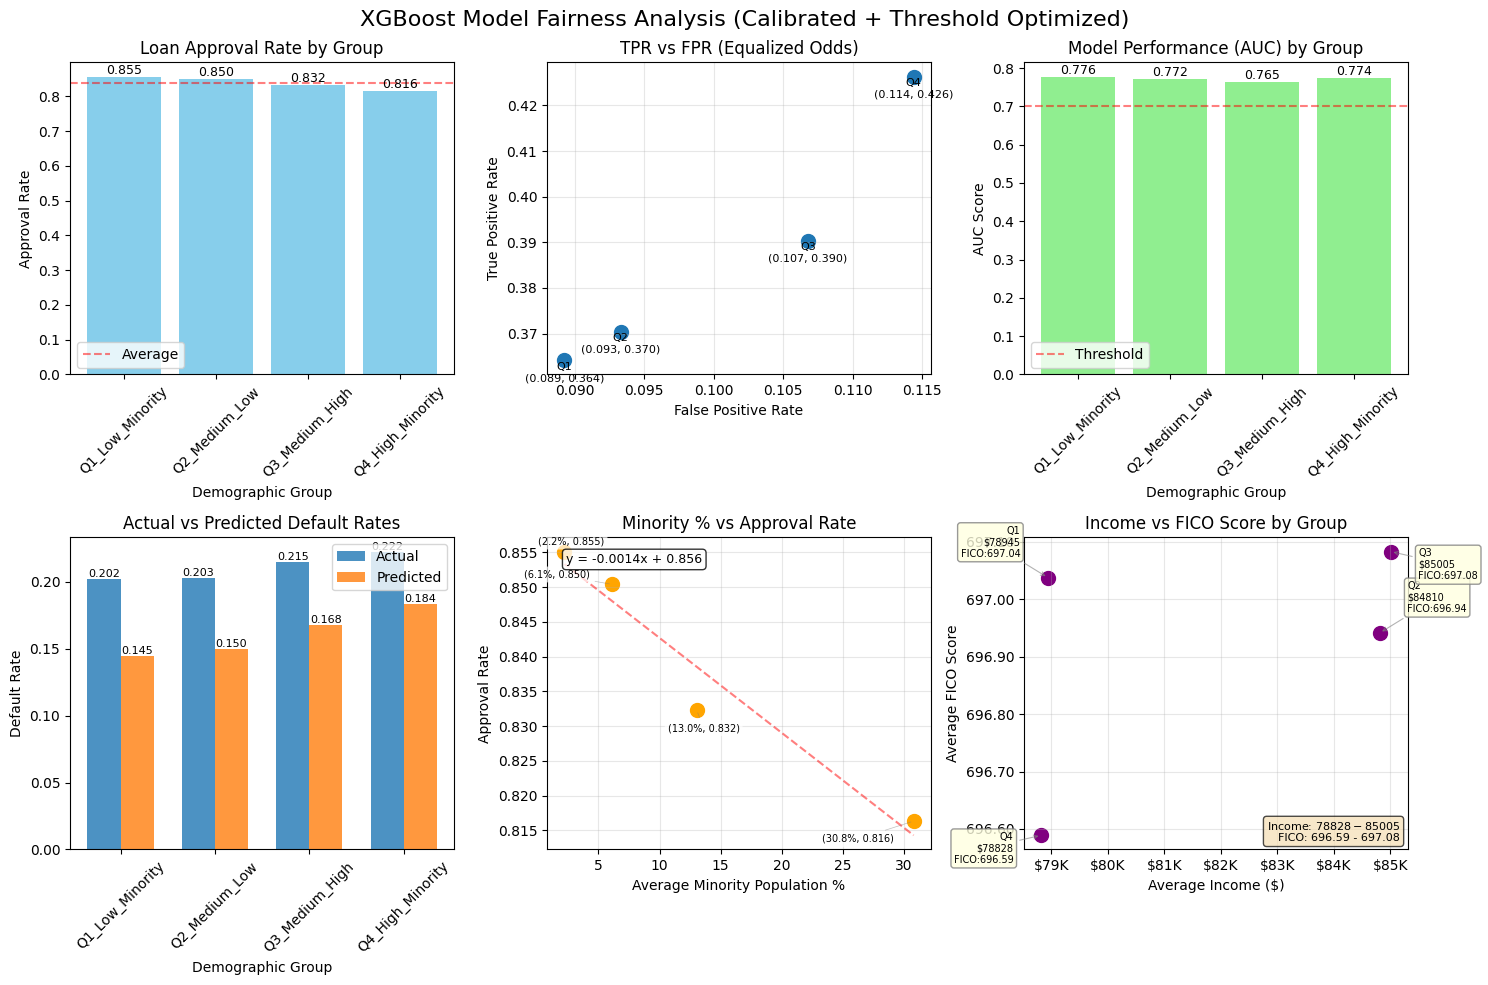

In [32]:
print("=" * 70)
print("STEP 9: Evaluate XGBoost model fairness by race (Pct_afro_american) (cross-calibration + threshold search)")
print("=" * 70)

# Prepare features and labels (same as your original script)
X_full = df.drop(columns=['Unnamed: 0', 'target', 'Predictions', 'Predicted probabilities'])
y_full = df['target']

# Cross-calibration using CalibratedClassifierCV (no need to change original training logic)
calibrated_clf = CalibratedClassifierCV(estimator=final_pipe, method='isotonic', cv=5)
calibrated_clf.fit(X_full, y_full)

# Obtain full-sample "uncalibrated" and "calibrated" probabilities (uncalibrated from original pipeline, calibrated from calibrated_clf)
p_full_uncal = final_pipe.predict_proba(X_full)[:, 1]
p_full_cal = calibrated_clf.predict_proba(X_full)[:, 1]

# Self-check: Brier score (full-sample, leakage-free calibration)
brier_before = brier_score_loss(y_full, p_full_uncal)
brier_after  = brier_score_loss(y_full, p_full_cal)
print(f"[Cross-calibration self-check] Brier before: {brier_before:.4f} -> after: {brier_after:.4f}")

# Threshold search (based on calibrated probabilities)
threshold_grid = np.linspace(0.05, 0.95, 19)
actual_default_overall = y_full.mean()
best_th = None
best_gap = 1.0
records = []
for th in threshold_grid:
    y_pred_cal = (p_full_cal >= th).astype(int)
    predicted_default_overall = y_pred_cal.mean()
    gap = abs(actual_default_overall - predicted_default_overall)
    auc_val = roc_auc_score(y_full, p_full_cal)
    records.append((th, predicted_default_overall, gap, auc_val))
    if gap < best_gap:
        best_gap = gap
        best_th = th

print(f"[Threshold search] Actual overall default rate: {actual_default_overall:.3f}")
print(f"[Threshold search] Optimal threshold: {best_th:.2f}, Predicted overall default rate: {dict((r[0], r[1]) for r in records)[best_th]:.3f}, Gap: {best_gap:.3f}")

# Write back uncalibrated/calibrated probabilities and predictions based on optimal threshold to df (full sample)
for c in ['xgb_pred', 'xgb_pred_proba', 'xgb_pred_cal', 'xgb_pred_proba_cal', 'demographic_group']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

df['xgb_pred_proba'] = p_full_uncal
df['xgb_pred'] = (p_full_uncal >= 0.5).astype(int)  # Uncalibrated comparison uses 0.5

df['xgb_pred_proba_cal'] = p_full_cal
df['xgb_pred_cal'] = (p_full_cal >= best_th).astype(int)  # Calibrated uses the optimal threshold found

# Demographic group partition
def create_demographic_groups(df_in, column='Pct_afro_american'):
    quartiles = df_in[column].quantile([0.25, 0.5, 0.75])
    conditions = [
        df_in[column] <= quartiles.iloc[0],
        (df_in[column] > quartiles.iloc[0]) & (df_in[column] <= quartiles.iloc[1]),
        (df_in[column] > quartiles.iloc[1]) & (df_in[column] <= quartiles.iloc[2]),
        df_in[column] > quartiles.iloc[2]
    ]
    choices = ['Q1_Low_Minority', 'Q2_Medium_Low', 'Q3_Medium_High', 'Q4_High_Minority']
    df_in['demographic_group'] = np.select(conditions, choices, default='Unknown')
    print("\nDemographic group statistics:")
    for group in choices:
        group_df = df_in[df_in['demographic_group'] == group]
        if len(group_df) == 0:
            continue
        print(f"{group}:")
        print(f"  Sample size: {len(group_df)}")
        print(f"  African American percentage range: {group_df[column].min():.2f}% - {group_df[column].max():.2f}%")
        print(f"  Average percentage: {group_df[column].mean():.2f}%")
    return df_in

df = create_demographic_groups(df)

import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss, roc_auc_score
from scipy.optimize import minimize_scalar

def optimize_group_specific_thresholds(df, prob_col='xgb_pred_proba_cal', 
                                       target_col='target', 
                                       group_col='demographic_group'):
    """
    Find an optimal threshold for each group to align predicted default rate with actual default rate
    """
    print("\n" + "=" * 60)
    print("Group-specific threshold optimization")
    print("=" * 60)
    
    group_thresholds = {}
    results = []
    
    for group in sorted(df[group_col].unique()):
        group_df = df[df[group_col] == group]
        y_true = group_df[target_col].values
        y_prob = group_df[prob_col].values
        
        actual_rate = y_true.mean()
        
        # Objective: minimize the difference between predicted rate and actual rate
        def objective(threshold):
            pred_rate = (y_prob >= threshold).mean()
            return abs(pred_rate - actual_rate)
        
        # Search for the optimal threshold
        result = minimize_scalar(objective, bounds=(0.1, 0.9), method='bounded')
        optimal_threshold = result.x
        
        # Compute metrics using the optimal threshold
        y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
        pred_rate_optimal = y_pred_optimal.mean()
        
        group_thresholds[group] = optimal_threshold
        
        results.append({
            'Group': group,
            'Actual_Rate': actual_rate,
            'Pred_Rate_Fixed': (y_prob >= 0.35).mean(),  # Fixed threshold
            'Pred_Rate_Optimal': pred_rate_optimal,      # Optimized threshold
            'Threshold_Fixed': 0.35,
            'Threshold_Optimal': optimal_threshold,
            'Gap_Fixed': abs((y_prob >= 0.35).mean() - actual_rate),
            'Gap_Optimal': abs(pred_rate_optimal - actual_rate)
        })
    
    results_df = pd.DataFrame(results)
    print("\nGroup-specific threshold results:")
    print(results_df.round(4).to_string(index=False))
    
    # Apply group-specific thresholds
    df['xgb_pred_group_optimal'] = 0
    for group, threshold in group_thresholds.items():
        mask = df[group_col] == group
        df.loc[mask, 'xgb_pred_group_optimal'] = (
            df.loc[mask, prob_col] >= threshold
        ).astype(int)
    
    return df, group_thresholds, results_df

# Execute group-specific threshold optimization
df, group_thresholds, threshold_results = optimize_group_specific_thresholds(df)

# Fairness metrics function
from sklearn.metrics import confusion_matrix

def calculate_fairness_metrics(df_in, pred_col='xgb_pred', pred_proba_col='xgb_pred_proba',
                               target_col='target', group_col='demographic_group'):
    metrics_list = []
    for group in sorted(df_in[group_col].unique()):
        group_df = df_in[df_in[group_col] == group]
        n = len(group_df)
        tn, fp, fn, tp = confusion_matrix(group_df[target_col], group_df[pred_col]).ravel()
        accuracy = (tp + tn) / n
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        default_pred_rate = group_df[pred_col].mean()
        actual_default_rate = group_df[target_col].mean()
        approval_rate = 1 - default_pred_rate
        try:
            auc = roc_auc_score(group_df[target_col], group_df[pred_proba_col])
        except Exception:
            auc = np.nan
        metrics_list.append({
            'Group': group,
            'Sample_Size': n,
            'Avg_Minority_%': group_df['Pct_afro_american'].mean(),
            'Approval_Rate': approval_rate,
            'Actual_Default_Rate': actual_default_rate,
            'Predicted_Default_Rate': default_pred_rate,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall(TPR)': recall,
            'FPR': fpr,
            'AUC': auc,
            'Avg_Interest_Rate': group_df['int_rate'].mean(),
            'Avg_Income': group_df['annual_inc'].mean(),
            'Avg_FICO': group_df['fico_range_high'].mean()
        })
    return pd.DataFrame(metrics_list)

# Compute fairness metrics and print "Actual vs Predicted" gaps
fairness_df_uncal = calculate_fairness_metrics(df, pred_col='xgb_pred', pred_proba_col='xgb_pred_proba')
fairness_df_cal   = calculate_fairness_metrics(df, pred_col='xgb_pred_cal', pred_proba_col='xgb_pred_proba_cal')

print("\n" + "=" * 50)
print("Fairness metrics summary (uncalibrated, threshold 0.5):")
print("=" * 50)
print(fairness_df_uncal.round(3).to_string(index=False))

print("\n" + "=" * 50)
print(f"Fairness metrics summary (calibrated, threshold {best_th:.2f}):")
print("=" * 50)
print(fairness_df_cal.round(3).to_string(index=False))

# Fairness criteria evaluation
def evaluate_fairness_criteria(fairness_df):
    print("\n" + "=" * 50)
    print("Fairness criteria evaluation:")
    print("=" * 50)
    print("\n1. Adverse Impact (4/5 Rule):")
    reference_group = 'Q1_Low_Minority'
    ref_approval = fairness_df[fairness_df['Group'] == reference_group]['Approval_Rate'].values[0]
    print(f"   Reference group ({reference_group}) approval rate: {ref_approval:.3f}")
    for _, row in fairness_df.iterrows():
        if row['Group'] != reference_group:
            di_ratio = row['Approval_Rate'] / ref_approval if ref_approval > 0 else 0
            status = "✓ Compliant" if di_ratio >= 0.8 else "✗ Violates"
            print(f"   {row['Group']}: {row['Approval_Rate']:.3f} (ratio: {di_ratio:.3f}) {status}")

    print("\n2. Demographic Parity:")
    dp_diff = fairness_df['Approval_Rate'].max() - fairness_df['Approval_Rate'].min()
    print(f"   Max difference: {dp_diff:.3f} -> {'✓ Small' if dp_diff < 0.1 else '✗ Significant'}")

    print("\n3. Equalized Odds:")
    tpr_diff = fairness_df['Recall(TPR)'].max() - fairness_df['Recall(TPR)'].min()
    fpr_diff = fairness_df['FPR'].max() - fairness_df['FPR'].min()
    print(f"   TPR difference: {tpr_diff:.3f}, FPR difference: {fpr_diff:.3f} -> {'✓ Satisfied' if (tpr_diff < 0.1 and fpr_diff < 0.1) else '✗ Not satisfied'}")

print("\n" + "=" * 50)
print("Fairness criteria evaluation (calibrated + optimal threshold):")
print("=" * 50)
evaluate_fairness_criteria(fairness_df_cal)

# Plotting (based on calibrated fairness_df_cal) - with data labels
fairness_df = fairness_df_cal

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('XGBoost Model Fairness Analysis (Calibrated + Threshold Optimized)', fontsize=16)

# Approval rate - add data labels
bars1 = axes[0, 0].bar(fairness_df['Group'], fairness_df['Approval_Rate'], color='skyblue')
axes[0, 0].set_title('Loan Approval Rate by Group')
axes[0, 0].set_ylabel('Approval Rate')
axes[0, 0].set_xlabel('Demographic Group')
axes[0, 0].axhline(y=fairness_df['Approval_Rate'].mean(), color='r', linestyle='--', alpha=0.5, label='Average')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
# Add data labels
for bar in bars1:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# TPR vs FPR - add values
axes[0, 1].scatter(fairness_df['FPR'], fairness_df['Recall(TPR)'], s=100)
for i, txt in enumerate(fairness_df['Group']):
    # Show coordinate values of the points
    axes[0, 1].annotate(f"{txt.split('_')[0]}\n({fairness_df['FPR'].iloc[i]:.3f}, {fairness_df['Recall(TPR)'].iloc[i]:.3f})",
                        (fairness_df['FPR'].iloc[i], fairness_df['Recall(TPR)'].iloc[i]),
                        fontsize=8, ha='center', xytext=(0, -15), textcoords='offset points')
axes[0, 1].set_title('TPR vs FPR (Equalized Odds)')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)

# AUC - add data labels
bars3 = axes[0, 2].bar(fairness_df['Group'], fairness_df['AUC'], color='lightgreen')
axes[0, 2].set_title('Model Performance (AUC) by Group')
axes[0, 2].set_ylabel('AUC Score')
axes[0, 2].set_xlabel('Demographic Group')
axes[0, 2].axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Threshold')
axes[0, 2].legend()
axes[0, 2].tick_params(axis='x', rotation=45)
# Add data labels
for bar in bars3:
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=9)

# Actual vs Predicted default rate - add data labels
x = np.arange(len(fairness_df['Group']))
width = 0.35
bars4_1 = axes[1, 0].bar(x - width/2, fairness_df['Actual_Default_Rate'], width, label='Actual', alpha=0.8)
bars4_2 = axes[1, 0].bar(x + width/2, fairness_df['Predicted_Default_Rate'], width, label='Predicted', alpha=0.8)
axes[1, 0].set_title('Actual vs Predicted Default Rates')
axes[1, 0].set_xlabel('Demographic Group')
axes[1, 0].set_ylabel('Default Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(fairness_df['Group'], rotation=45)
axes[1, 0].legend()
# Add data labels
for bar in bars4_1:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)
for bar in bars4_2:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)

# Minority % vs Approval rate - optimized label placement
axes[1, 1].scatter(fairness_df['Avg_Minority_%'], fairness_df['Approval_Rate'], s=100, color='orange')
axes[1, 1].set_title('Minority % vs Approval Rate')
axes[1, 1].set_xlabel('Average Minority Population %')
axes[1, 1].set_ylabel('Approval Rate')

# Add trend line
z = np.polyfit(fairness_df['Avg_Minority_%'], fairness_df['Approval_Rate'], 1)
p = np.poly1d(z)
axes[1, 1].plot(fairness_df['Avg_Minority_%'], p(fairness_df['Avg_Minority_%']), "r--", alpha=0.5)

# Smartly adjust label positions to avoid overlap
offsets = [(5, 5), (-40, 5), (5, -15), (-40, -15)]  # Different offsets for each point
for i in range(len(fairness_df)):
    # Use different offsets to avoid overlap
    offset = offsets[i % len(offsets)]
    axes[1, 1].annotate(f"({fairness_df['Avg_Minority_%'].iloc[i]:.1f}%, {fairness_df['Approval_Rate'].iloc[i]:.3f})",
                        (fairness_df['Avg_Minority_%'].iloc[i], fairness_df['Approval_Rate'].iloc[i]),
                        fontsize=7,  # Slightly smaller font
                        xytext=offset, 
                        textcoords='offset points',
                        ha='center',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'),  # White background
                        arrowprops=dict(arrowstyle='-', lw=0.5, color='gray', alpha=0.5))  # Fine leader line

axes[1, 1].grid(True, alpha=0.3)

# Add trend line equation
equation_text = f'y = {z[0]:.4f}x + {z[1]:.3f}'
axes[1, 1].text(0.05, 0.95, equation_text, transform=axes[1, 1].transAxes, 
                fontsize=9, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Income vs FICO - optimized label placement
axes[1, 2].scatter(fairness_df['Avg_Income'], fairness_df['Avg_FICO'], s=100, color='purple')

# Smart label placement for Income vs FICO chart
fico_values = fairness_df['Avg_FICO'].values
income_values = fairness_df['Avg_Income'].values

for i, txt in enumerate(fairness_df['Group']):
    # Decide label placement direction based on point positions
    if i == 0:  # Q1
        offset = (-20, 15)
        ha = 'right'
    elif i == 1:  # Q2
        offset = (20, 15)
        ha = 'left'
    elif i == 2:  # Q3
        offset = (20, -20)
        ha = 'left'
    else:  # Q4
        offset = (-20, -20)
        ha = 'right'
    
    # Show group name and values (rounded)
    axes[1, 2].annotate(f"{txt.split('_')[0]}\n${fairness_df['Avg_Income'].iloc[i]:.0f}\nFICO:{fairness_df['Avg_FICO'].iloc[i]:.2f}",
                        (fairness_df['Avg_Income'].iloc[i], fairness_df['Avg_FICO'].iloc[i]),
                        fontsize=7,  # Smaller font
                        ha=ha,
                        xytext=offset, 
                        textcoords='offset points',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.8, edgecolor='gray'),
                        arrowprops=dict(arrowstyle='->', lw=0.8, color='gray', alpha=0.6))

axes[1, 2].set_title('Income vs FICO Score by Group')
axes[1, 2].set_xlabel('Average Income ($)')
axes[1, 2].set_ylabel('Average FICO Score')
axes[1, 2].grid(True, alpha=0.3)

# Show more decimals on Y-axis
axes[1, 2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

# Format X-axis (income) in thousands
axes[1, 2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add detailed stats box (position adjusted to avoid overlap)
stats_text = "Income: ${:.0f} - ${:.0f}\nFICO: {:.2f} - {:.2f}".format(
    fairness_df['Avg_Income'].min(),
    fairness_df['Avg_Income'].max(),
    fairness_df['Avg_FICO'].min(),
    fairness_df['Avg_FICO'].max()
)
axes[1, 2].text(0.98, 0.02, stats_text, transform=axes[1, 2].transAxes,
                fontsize=8, 
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.show()

## Step 10.

In [ ]:
class DPAccountant:
    """Simple epsilon accountant to track/allocate privacy budget"""
    def __init__(self, total_epsilon: float, delta: float = 0.0, allocation: str = "uniform"):
        """
        total_epsilon: total privacy budget
        delta: δ required for Gaussian mechanism
        allocation: budget allocation strategy
        """
        self.total_epsilon = float(total_epsilon)
        self.delta = float(delta)
        self.consumed = 0.0
        self.allocation = allocation

    @property
    def remaining(self) -> float:
        return max(0.0, self.total_epsilon - self.consumed)

    def spend(self, eps: float):
        eps = float(eps)
        self.consumed += eps
        if self.consumed > self.total_epsilon + 1e-12:
            warnings.warn(f"Privacy budget exceeded: consumed {self.consumed:.4f} > total {self.total_epsilon:.4f}")

def _laplace_noise(scale: float, size=None):
    return np.random.laplace(loc=0.0, scale=scale, size=size)

def _gaussian_noise(std: float, size=None):
    return np.random.normal(loc=0.0, scale=std, size=size)

def dp_count(count: float, epsilon: float, mechanism: str = "laplace", delta: float = 0.0, sensitivity: float = 1.0):
    """
    Add DP noise to counts (e.g., TP, FP). Returns non-negative value.
    """
    if epsilon <= 0:
        raise ValueError("epsilon must be > 0 for DP query.")
    if mechanism == "laplace":
        scale = sensitivity / epsilon
        noisy = count + _laplace_noise(scale)
    elif mechanism == "gaussian":
        # Gaussian mechanism ((ε, δ)-DP) needs σ; use a simplified approximation of the analytic Gaussian mechanism
        # Simplified: σ = sqrt(2 * ln(1.25/δ)) * sensitivity / ε
        if delta <= 0:
            raise ValueError("Gaussian mechanism requires delta > 0.")
        std = (np.sqrt(2 * np.log(1.25 / delta)) * sensitivity) / epsilon
        noisy = count + _gaussian_noise(std)
    else:
        raise ValueError("Unknown mechanism.")
    return max(0.0, noisy)

def ratio_safe(num: float, den: float) -> float:
    return 0.0 if den <= 0 else max(0.0, min(1.0, num / den))

class FairPrivatePostProcessorForXGBoost:
    """
    True FPDP: Fairness post-processing + Differential Privacy
    - Protects the post-training processing and metric reporting stages by adding noise to statistics
    - Improves fairness via per-group threshold optimization
    """
    def __init__(
        self,
        fairness_constraint: str = 'demographic_parity',
        epsilon_fair: float = 0.0,         # Fairness tolerance band (not DP ε)
        alpha: float = 0.5,                # Fairness-accuracy trade-off
        # DP parameters
        total_epsilon: float = 1.0,        # Total privacy budget (smaller = more private)
        mechanism: str = "laplace",        # 'laplace' or 'gaussian'
        delta: float = 1e-6,               # Required for Gaussian mechanism
        eps_per_query: float = 0.01,       # ε consumed per statistics query
        min_group_size: int = 30,          # Robustness threshold for small groups
        threshold_bounds=(0.05, 0.95),     # Threshold search range
        baseline_threshold: float = 0.5,   # Baseline threshold
    ):
        self.fairness_constraint = fairness_constraint
        self.epsilon_fair = float(epsilon_fair)
        self.alpha = float(alpha)
        self.accountant = DPAccountant(total_epsilon=total_epsilon, delta=delta)
        self.mechanism = mechanism
        self.delta = delta
        self.eps_per_query = float(eps_per_query)
        self.min_group_size = int(min_group_size)
        self.threshold_bounds = threshold_bounds
        self.baseline_threshold = float(baseline_threshold)

        self.group_thresholds = {}
        self.performance_before = {}
        self.performance_after = {}
        self.target_approval_rate = None
        self.target_tpr = None
        self.target_fpr = None

    # -------- DP statistics wrapper (all sensitive stats go through here) --------
    def _dp_tp_fp_tn_fn(self, y_true: np.ndarray, y_pred: np.ndarray):
        tp = int(np.sum((y_true == 1) & (y_pred == 1)))
        fp = int(np.sum((y_true == 0) & (y_pred == 1)))
        tn = int(np.sum((y_true == 0) & (y_pred == 0)))
        fn = int(np.sum((y_true == 1) & (y_pred == 0)))
        # Each count is one query
        tp_n = dp_count(tp, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        fp_n = dp_count(fp, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        tn_n = dp_count(tn, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        fn_n = dp_count(fn, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        return tp_n, fp_n, tn_n, fn_n

    def _dp_approval_rate(self, y_pred: np.ndarray, approve_when_zero: bool = True) -> float:
        """
        If prediction 1 means "reject/bad", approval rate = proportion predicted 0; otherwise vice versa.
        Here we follow your original semantics: pred=1 means reject, so approval rate = 1 - mean(pred)
        """
        n = len(y_pred)
        ones = int(np.sum(y_pred == 1))
        # Query ones and n-ones
        ones_n = dp_count(ones, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        zeros_n = dp_count(n - ones, self.eps_per_query, self.mechanism, self.delta)
        self.accountant.spend(self.eps_per_query)
        total_n = ones_n + zeros_n
        if total_n <= 0:
            return 0.0
        if approve_when_zero:
            return max(0.0, min(1.0, zeros_n / total_n))
        else:
            return max(0.0, min(1.0, ones_n / total_n))

    def _dp_tpr_fpr(self, y_true: np.ndarray, y_pred: np.ndarray):
        tp_n, fp_n, tn_n, fn_n = self._dp_tp_fp_tn_fn(y_true, y_pred)
        tpr = ratio_safe(tp_n, tp_n + fn_n)
        fpr = ratio_safe(fp_n, fp_n + tn_n)
        return tpr, fpr

    # -------- Fit/train (threshold optimization) --------
    def fit(self, df: pd.DataFrame, prob_col='xgb_pred_proba', group_col='demographic_group', target_col='target'):
        print("\n[FPDP] Start fitting with privacy + fairness post-processing...")
        print(f"Fairness = {self.fairness_constraint}, alpha={self.alpha}, epsilon_fair={self.epsilon_fair}")
        print(f"DP: total ε={self.accountant.total_epsilon}, per-query ε={self.eps_per_query}, mechanism={self.mechanism}, δ={self.delta}")

        groups = sorted(df[group_col].unique())

        # Compute global targets (using DP statistics)
        preds_baseline = (df[prob_col].values > self.baseline_threshold).astype(int)
        y_all = df[target_col].values

        if self.fairness_constraint == 'demographic_parity':
            # Global approval rate (protected with DP noise)
            self.target_approval_rate = self._dp_approval_rate(preds_baseline)
            print(f"DP target approval rate (private): {self.target_approval_rate:.4f}")
        elif self.fairness_constraint in ('equal_opportunity', 'equalized_odds'):
            tpr_all, fpr_all = self._dp_tpr_fpr(y_all, preds_baseline)
            self.target_tpr = tpr_all
            self.target_fpr = fpr_all
            print(f"DP target TPR/FPR (private): TPR={self.target_tpr:.4f}, FPR={self.target_fpr:.4f}")
        else:
            raise ValueError("Unsupported fairness_constraint.")

        # Optimize thresholds per group
        for g in groups:
            gdf = df[df[group_col] == g]
            probs = gdf[prob_col].values
            y = gdf[target_col].values

            if len(gdf) < self.min_group_size:
                warnings.warn(f"Group {g} has small size {len(gdf)} < {self.min_group_size}. "
                              f"Using baseline threshold {self.baseline_threshold:.2f}.")
                self.group_thresholds[g] = self.baseline_threshold
                # Record performance (baseline)
                base_pred = (probs > self.baseline_threshold).astype(int)
                acc_b = accuracy_score(y, base_pred)
                acc_a = acc_b
                appr_b = 1.0 - base_pred.mean()
                appr_a = appr_b
                self.performance_before[g] = {'accuracy': acc_b, 'approval_rate': appr_b}
                self.performance_after[g]  = {'accuracy': acc_a, 'approval_rate': appr_a}
                continue

            def objective(th):
                th = float(th)
                pred = (probs > th).astype(int)

                # Accuracy loss (non-private, used as internal measure; for strict DP, also add noise or use an acceptable proxy)
                acc = accuracy_score(y, pred)
                acc_loss = 1.0 - acc

                # Fairness loss (using DP statistics)
                if self.fairness_constraint == 'demographic_parity':
                    appr = self._dp_approval_rate(pred)
                    diff = abs(appr - self.target_approval_rate)
                    fair_loss = max(0.0, diff - self.epsilon_fair)
                elif self.fairness_constraint == 'equal_opportunity':
                    tpr, _ = self._dp_tpr_fpr(y, pred)
                    diff = abs(tpr - self.target_tpr)
                    fair_loss = max(0.0, diff - self.epsilon_fair)
                else:  # equalized_odds
                    tpr, fpr = self._dp_tpr_fpr(y, pred)
                    diff = abs(tpr - self.target_tpr) + abs(fpr - self.target_fpr)
                    fair_loss = max(0.0, diff - self.epsilon_fair)

                return (1.0 - self.alpha) * acc_loss + self.alpha * fair_loss

            res = minimize_scalar(objective, bounds=self.threshold_bounds, method='bounded')
            t_opt = float(np.clip(res.x, *self.threshold_bounds))
            self.group_thresholds[g] = t_opt

            # Record pre/post performance (reporting stage also uses DP for fairness metrics; accuracy can be reported privately or with noise)
            base_pred = (probs > self.baseline_threshold).astype(int)
            opt_pred  = (probs > t_opt).astype(int)

            self.performance_before[g] = {
                'accuracy': accuracy_score(y, base_pred),
                'approval_rate': 1.0 - base_pred.mean()
            }
            self.performance_after[g]  = {
                'accuracy': accuracy_score(y, opt_pred),
                'approval_rate': 1.0 - opt_pred.mean()
            }

        print("[FPDP] Optimization finished.")
        print(f"Privacy budget consumed ε = {self.accountant.consumed:.4f} / {self.accountant.total_epsilon:.4f} (remaining {self.accountant.remaining:.4f})")
        return self

    # -------- Predict --------
    def transform(self, df: pd.DataFrame, prob_col='xgb_pred_proba', group_col='demographic_group'):
        preds = np.zeros(len(df), dtype=int)
        for g, th in self.group_thresholds.items():
            mask = (df[group_col] == g).values
            if mask.any():
                preds[mask] = (df.loc[mask, prob_col].values > th).astype(int)
        return preds

    # -------- Private summary (return fairness metrics after adding noise) --------
    def private_summary(self, df: pd.DataFrame, prob_col='xgb_pred_proba', group_col='demographic_group', target_col='target'):
        rows = []
        for g, th in self.group_thresholds.items():
            gdf = df[df[group_col] == g]
            probs = gdf[prob_col].values
            y = gdf[target_col].values
            base_pred = (probs > self.baseline_threshold).astype(int)
            opt_pred  = (probs > th).astype(int)

            # Fairness metrics: use DP statistics
            appr_b = self._dp_approval_rate(base_pred)
            appr_a = self._dp_approval_rate(opt_pred)
            tpr_b, fpr_b = self._dp_tpr_fpr(y, base_pred)
            tpr_a, fpr_a = self._dp_tpr_fpr(y, opt_pred)

            rows.append({
                'Group': g,
                'Threshold': th,
                'Approval_Before(DP)': appr_b,
                'Approval_After(DP)': appr_a,
                'TPR_Before(DP)': tpr_b,
                'TPR_After(DP)': tpr_a,
                'FPR_Before(DP)': fpr_b,
                'FPR_After(DP)': fpr_a,
                # Optional: non-private accuracy (if publishing externally, consider adding noise or reporting relative change only)
                'Accuracy_Before': accuracy_score(y, base_pred),
                'Accuracy_After': accuracy_score(y, opt_pred),
            })
        print(f"[FPDP] Summary consumed ε so far: {self.accountant.consumed:.4f}/{self.accountant.total_epsilon:.4f}")
        return pd.DataFrame(rows)

# ================= Usage example =================
# Assume df contains columns:
# - 'xgb_pred_proba': XGBoost predicted probability
# - 'demographic_group': group
# - 'target': label (1=bad/reject, 0=good/approve), consistent with your original semantics

# 1) Demographic Parity + DP
fpdp_dp = FairPrivatePostProcessorForXGBoost(
    fairness_constraint='demographic_parity',
    epsilon_fair=0.02,     # Tolerance band: no penalty if group approval rates differ within 2%
    alpha=0.7,
    total_epsilon=2.0,     # Total privacy budget; smaller is more private
    mechanism='laplace',
    eps_per_query=0.02,
    min_group_size=30
).fit(df)

df['fair_pred_dp'] = fpdp_dp.transform(df)
summary_dp_private = fpdp_dp.private_summary(df)

# 2) Equal Opportunity + DP
fpdp_eo = FairPrivatePostProcessorForXGBoost(
    fairness_constraint='equal_opportunity',
    epsilon_fair=0.02,
    alpha=0.5,
    total_epsilon=2.0,
    mechanism='laplace',
    eps_per_query=0.02,
    min_group_size=30
).fit(df)

df['fair_pred_eo'] = fpdp_eo.transform(df)
summary_eo_private = fpdp_eo.private_summary(df)

print("\n=== FPDP (DP) Demographic Parity Private Summary ===")
print(summary_dp_private.round(4).to_string(index=False))

print("\n=== FPDP (DP) Equal Opportunity Private Summary ===")
print(summary_eo_private.round(4).to_string(index=False))


[FPDP] Start fitting with privacy + fairness post-processing...
Fairness = demographic_parity, alpha=0.7, epsilon_fair=0.02
DP: total ε=2.0, per-query ε=0.02, mechanism=laplace, δ=1e-06
DP target approval rate (private): 0.5874
[FPDP] Optimization finished.
Privacy budget consumed ε = 3.5200 / 2.0000 (remaining 0.0000)
[FPDP] Summary consumed ε so far: 4.4800/2.0000

[FPDP] Start fitting with privacy + fairness post-processing...
Fairness = equal_opportunity, alpha=0.5, epsilon_fair=0.02
DP: total ε=2.0, per-query ε=0.02, mechanism=laplace, δ=1e-06
DP target TPR/FPR (private): TPR=0.7377, FPR=0.3259
[FPDP] Optimization finished.
Privacy budget consumed ε = 6.1600 / 2.0000 (remaining 0.0000)
[FPDP] Summary consumed ε so far: 7.1200/2.0000

=== FPDP (DP) Demographic Parity Private Summary ===
           Group  Threshold  Approval_Before(DP)  Approval_After(DP)  TPR_Before(DP)  TPR_After(DP)  FPR_Before(DP)  FPR_After(DP)  Accuracy_Before  Accuracy_After
 Q1_Low_Minority     0.4976      

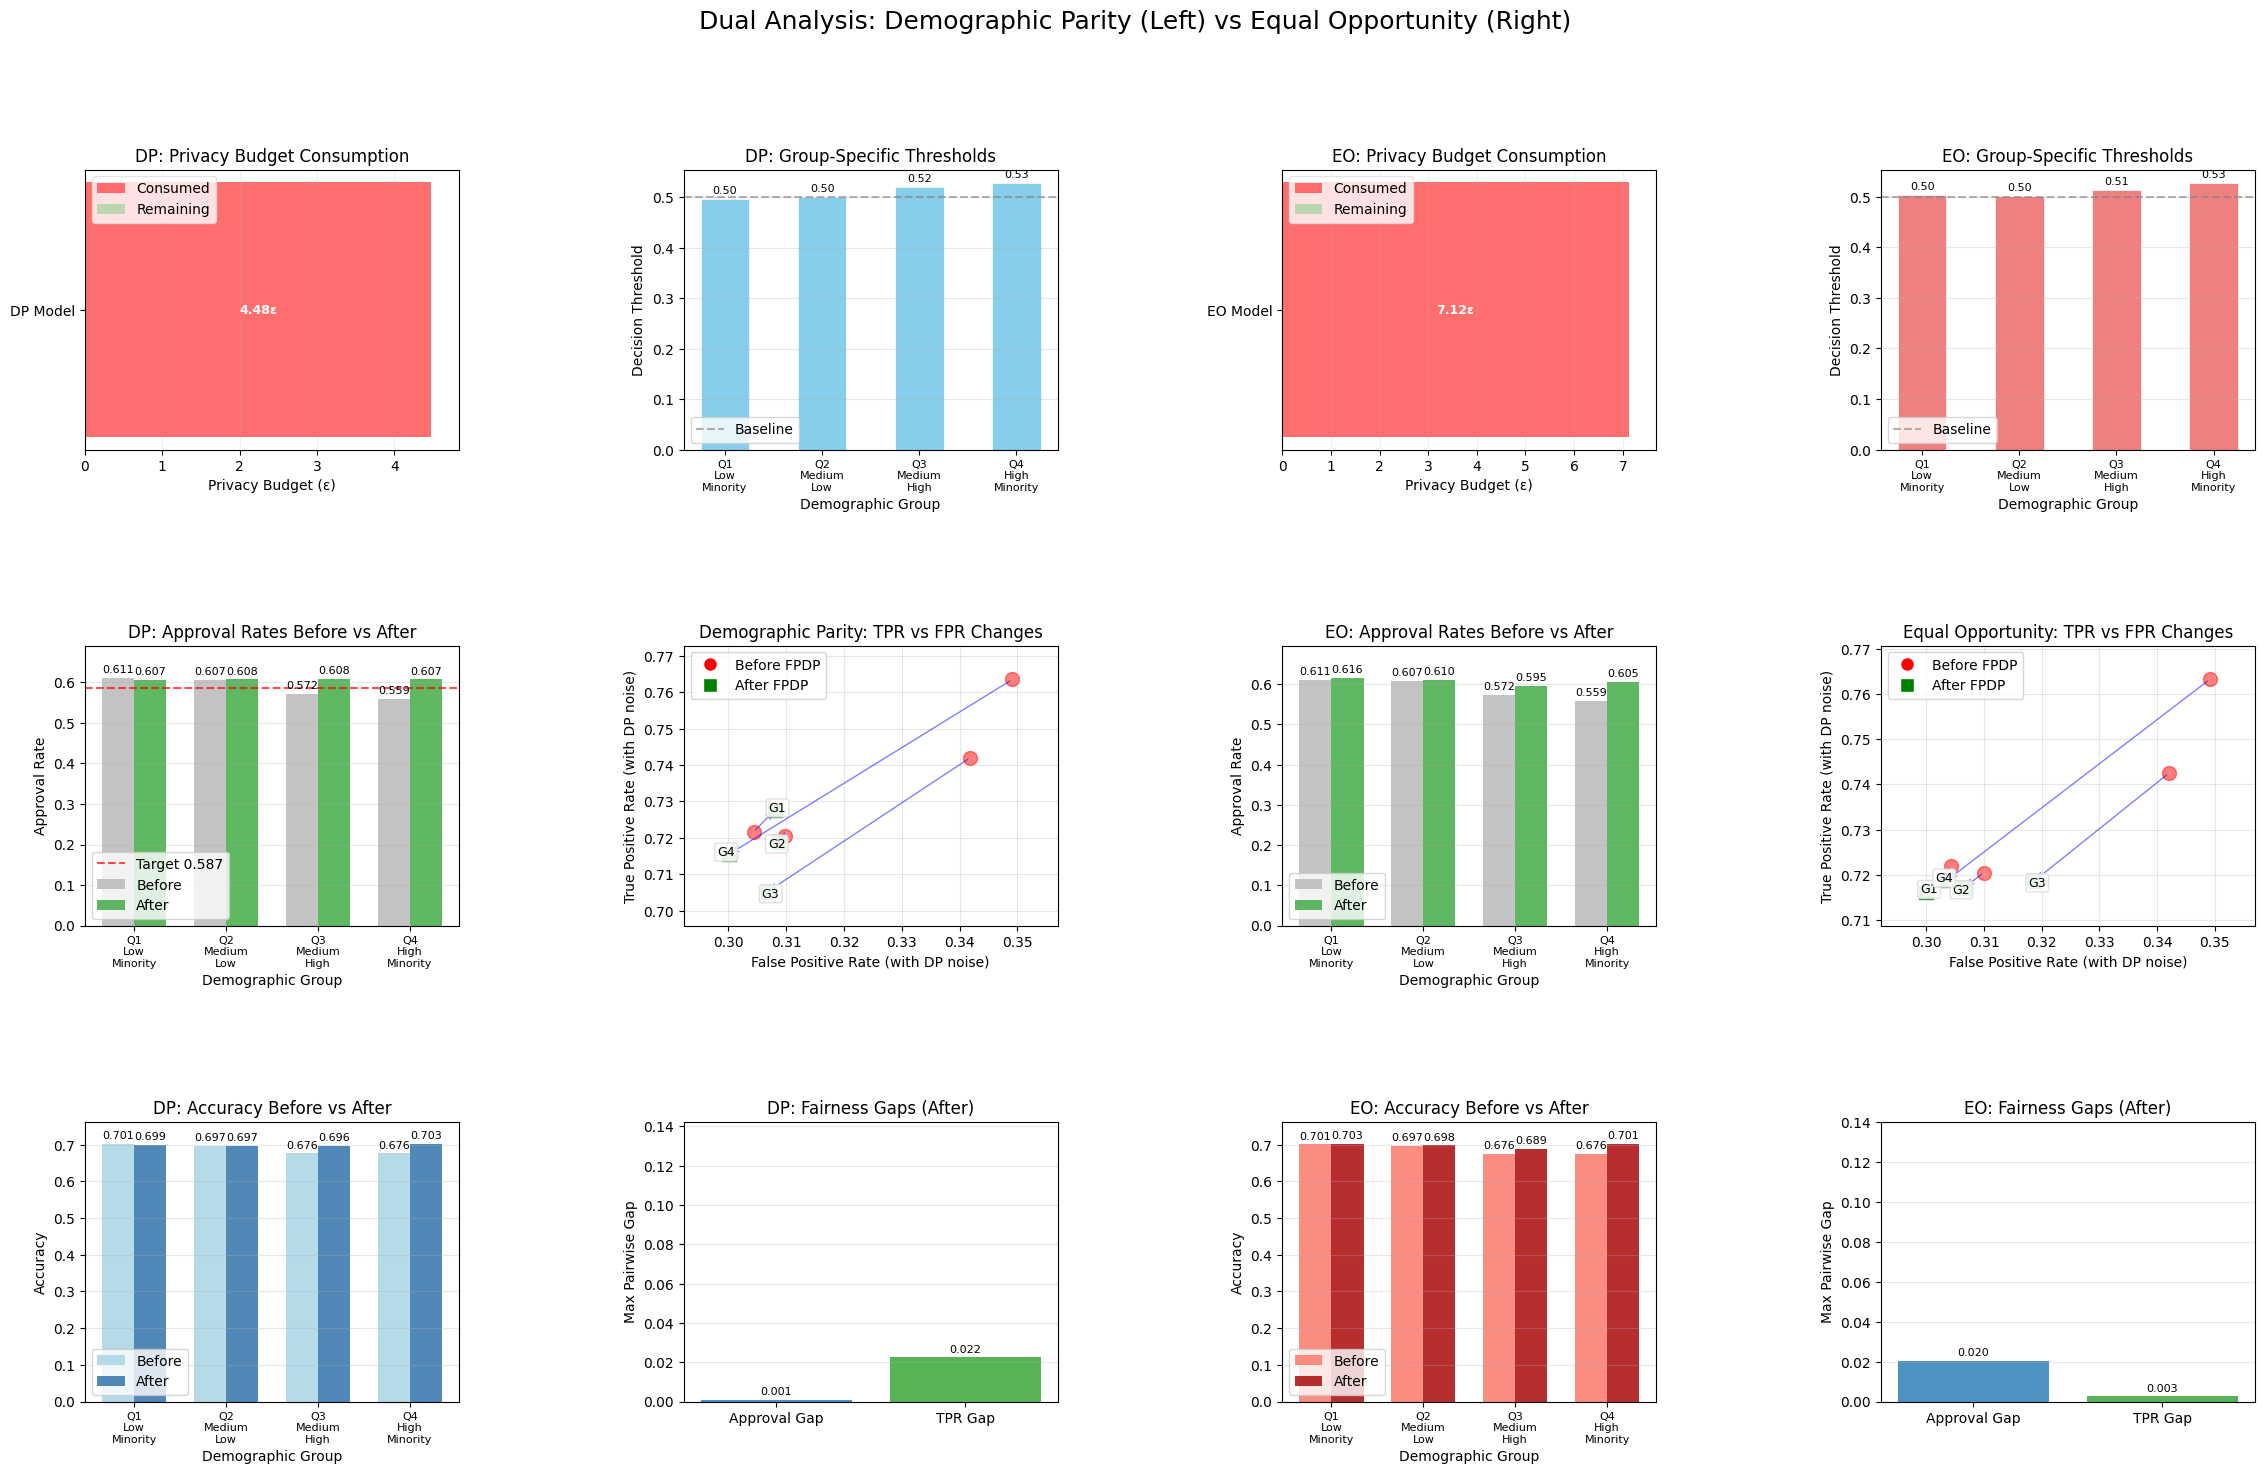


FAIR AND PRIVATE DATA PROCESSING (FPDP) - DETAILED REPORT

1. PRIVACY ANALYSIS
----------------------------------------
Demographic Parity Model:
  - Total Privacy Budget: ε = 2.0
  - Consumed Budget: ε = 4.4800
  - Remaining Budget: ε = 0.0000
  - Privacy Mechanism: laplace

Equal Opportunity Model:
  - Total Privacy Budget: ε = 2.0
  - Consumed Budget: ε = 7.1200
  - Remaining Budget: ε = 0.0000
  - Privacy Mechanism: laplace

2. FAIRNESS IMPROVEMENTS
----------------------------------------
Demographic Parity Constraint:
  - Approval Rate Gap Before: 0.0522
  - Approval Rate Gap After: 0.0008
  - Improvement: 98.4%

Equal Opportunity Constraint:
  - TPR Gap Before: 0.0427
  - TPR Gap After: 0.0025
  - Improvement: 94.1%

3. ACCURACY TRADE-OFFS
----------------------------------------
Demographic Parity Model:
  - Average Accuracy Before: 0.6874
  - Average Accuracy After: 0.6985
  - Accuracy Loss: -0.0112 (-1.6%)

Equal Opportunity Model:
  - Average Accuracy Before: 0.6874
  - Ave

In [ ]:
def visualize_fpdp_dual(df, fpdp_dp, fpdp_eo, summary_dp, summary_eo):
    # Helpers
    def _bar_labels_top(ax, bars, fmt='{:.3f}', dy_ratio=0.012, fontsize=8, color='black'):
        ymin, ymax = ax.get_ylim()
        span = ymax - ymin
        for b in bars:
            h = b.get_height()
            cx = b.get_x() + b.get_width()/2
            ax.text(cx, h + dy_ratio*span, fmt.format(h),
                    ha='center', va='bottom', fontsize=fontsize, color=color)

    def _add_scatter_table(ax, groups, header, rows, loc='bottom', fontsize=8):
        # rows: list of lists, each inner list is row values aligned with header
        # Build table data
        col_labels = header
        cell_text = rows
        if loc == 'right':
            table = ax.table(cellText=cell_text, colLabels=col_labels,
                             loc='right', cellLoc='center', colLoc='center',
                             bbox=[1.02, 0.0, 0.45, 1.0])
        else:
            # bottom
            table = ax.table(cellText=cell_text, colLabels=col_labels,
                             loc='bottom', cellLoc='center', colLoc='center',
                             bbox=[0.0, -0.42, 1.0, 0.38])
        table.auto_set_font_size(False)
        table.set_fontsize(fontsize)
        # Light borders
        for key, cell in table.get_celld().items():
            cell.set_edgecolor('#CCCCCC')
        return table

    # Figure
    fig = plt.figure(figsize=(28, 16))
    gs = fig.add_gridspec(3, 4, hspace=0.7, wspace=0.6)

    groups = list(fpdp_dp.group_thresholds.keys())
    x = np.arange(len(groups))

    # ========== LEFT COLUMN: DP ==========
    # 1L Privacy budget
    ax1L = fig.add_subplot(gs[0, 0])
    consumed = float(fpdp_dp.accountant.consumed)
    total = float(fpdp_dp.accountant.total_epsilon)
    remaining = max(total - consumed, 0.0)  # clip non-negative
    ax1L.barh(0, consumed, color='#ff5e5e', alpha=0.9, label='Consumed', edgecolor='none')
    ax1L.barh(0, remaining, left=consumed, color='#8fd18f', alpha=0.6, label='Remaining', edgecolor='none')
    # Centered labels inside each segment
    if consumed > 0:
        ax1L.text(consumed/2, 0, f'{consumed:.2f}ε', ha='center', va='center',
                  color='white', fontsize=9, fontweight='bold')
    if remaining > 0:
        ax1L.text(consumed + remaining/2, 0, f'{remaining:.2f}ε', ha='center', va='center',
                  color='black', fontsize=9)
    ax1L.set_yticks([0])
    ax1L.set_yticklabels(['DP Model'])
    ax1L.set_xlabel('Privacy Budget (ε)')
    ax1L.set_title('DP: Privacy Budget Consumption')
    ax1L.legend(frameon=True, facecolor='white', edgecolor='#dddddd')
    ax1L.set_xlim(0, max(total, consumed) * 1.08 + 1e-6)
    ax1L.grid(True, axis='x', alpha=0.2)

    # 2L Thresholds
    ax2L = fig.add_subplot(gs[0, 1])
    width = 0.5
    thr_dp = [fpdp_dp.group_thresholds[g] for g in groups]
    bars_thr_dp = ax2L.bar(x, thr_dp, width, color='skyblue', edgecolor='white', linewidth=0.5)
    baseline = getattr(fpdp_dp, 'baseline_threshold', 0.5)
    ax2L.axhline(y=baseline, color='gray', linestyle='--', alpha=0.6, label='Baseline')
    ax2L.set_xlabel('Demographic Group'); ax2L.set_ylabel('Decision Threshold')
    ax2L.set_title('DP: Group-Specific Thresholds')
    ax2L.set_xticks(x); ax2L.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax2L.legend()
    ax2L.grid(True, axis='y', alpha=0.3)
    # labels (top, black small)
    _bar_labels_top(ax2L, bars_thr_dp, fmt='{:.2f}', fontsize=8)

    # 3L Approval rates (unified black outside labels)
    ax3L = fig.add_subplot(gs[1, 0])
    appr_b_dp = summary_dp['Approval_Before(DP)'].values
    appr_a_dp = summary_dp['Approval_After(DP)'].values
    w = 0.35
    bars_b = ax3L.bar(x - w/2, appr_b_dp, w, color='#bdbdbd', label='Before', alpha=0.9)
    bars_a = ax3L.bar(x + w/2, appr_a_dp, w, color='#4caf50', label='After', alpha=0.9)
    if getattr(fpdp_dp, 'target_approval_rate', None) is not None:
        ax3L.axhline(fpdp_dp.target_approval_rate, color='red', linestyle='--', alpha=0.7,
                     label=f'Target {fpdp_dp.target_approval_rate:.3f}')
    ax3L.set_xlabel('Demographic Group'); ax3L.set_ylabel('Approval Rate')
    ax3L.set_title('DP: Approval Rates Before vs After')
    ax3L.set_xticks(x); ax3L.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax3L.grid(True, axis='y', alpha=0.3); ax3L.legend()
    ymax3 = min(1.0, max(appr_b_dp.max(), appr_a_dp.max()) + 0.08)
    ax3L.set_ylim(0, ymax3)
    _bar_labels_top(ax3L, bars_b, fontsize=8, color='black')
    _bar_labels_top(ax3L, bars_a, fontsize=8, color='black')

    # Figure 6 ---- DP
    ax6 = fig.add_subplot(gs[1, 1])  # place according to your layout

    tpr_before = summary_dp['TPR_Before(DP)'].values
    tpr_after  = summary_dp['TPR_After(DP)'].values
    # If missing FPR_* columns, replace with your own FPR data
    fpr_before = summary_dp['FPR_Before(DP)'].values if 'FPR_Before(DP)' in summary_dp else np.zeros_like(tpr_before)
    fpr_after  = summary_dp['FPR_After(DP)'].values if 'FPR_After(DP)'  in summary_dp else np.zeros_like(tpr_after)

    # Compute data range for margins
    x_all = np.r_[fpr_before, fpr_after]; y_all = np.r_[tpr_before, tpr_after]
    x_min, x_max = float(np.min(x_all)), float(np.max(x_all))
    y_min, y_max = float(np.min(y_all)), float(np.max(y_all))
    x_span = max(1e-6, x_max - x_min); y_span = max(1e-6, y_max - y_min)

    for i, g in enumerate(groups):
        ax6.scatter(fpr_before[i], tpr_before[i], s=100, alpha=0.5, color='red',   marker='o')
        ax6.scatter(fpr_after[i],  tpr_after[i],  s=100, alpha=0.8, color='green', marker='s')
        ax6.annotate('', xy=(fpr_after[i], tpr_after[i]),
                    xytext=(fpr_before[i], tpr_before[i]),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5))
        # Slight label offset to avoid covering the point
        dx = (0.010 if i % 2 == 0 else -0.010) * x_span
        dy = (0.010 if i % 3 == 0 else -0.010) * y_span
        ax6.text(fpr_after[i] + dx, tpr_after[i] + dy, f'G{i+1}', fontsize=9,
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='#dddddd', alpha=0.9))

    # Key: add margins to axes to "relax" points
    margin = 0.16  # increase to 0.18~0.22 for looser spacing
    ax6.set_xlim(max(0.0, x_min - margin * x_span), min(1.0, x_max + margin * x_span))
    ax6.set_ylim(max(0.0, y_min - margin * y_span), min(1.0, y_max + margin * y_span))

    ax6.set_xlabel('False Positive Rate (with DP noise)')
    ax6.set_ylabel('True Positive Rate (with DP noise)')
    ax6.set_title('Demographic Parity: TPR vs FPR Changes')
    ax6.grid(True, alpha=0.3)
    ax6.legend([plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',   markersize=10),
                plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10)],
            ['Before FPDP', 'After FPDP'])

    # 5L Accuracy (unified black outside labels)
    ax5L = fig.add_subplot(gs[2, 0])
    acc_b_dp = summary_dp['Accuracy_Before'].values
    acc_a_dp = summary_dp['Accuracy_After'].values
    width_small = 0.35
    bars_acc_b = ax5L.bar(x - width_small/2, acc_b_dp, width_small, label='Before', color='lightblue', alpha=0.9)
    bars_acc_a = ax5L.bar(x + width_small/2, acc_a_dp, width_small, label='After', color='steelblue', alpha=0.95)
    ax5L.set_xlabel('Demographic Group'); ax5L.set_ylabel('Accuracy')
    ax5L.set_title('DP: Accuracy Before vs After')
    ax5L.set_xticks(x); ax5L.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax5L.legend(); ax5L.grid(True, axis='y', alpha=0.3)
    ax5L.set_ylim(0, min(1.0, max(acc_b_dp.max(), acc_a_dp.max()) + 0.06))
    _bar_labels_top(ax5L, bars_acc_b, fontsize=8, color='black')
    _bar_labels_top(ax5L, bars_acc_a, fontsize=8, color='black')

    # 6L Fairness gaps (bars do not need to change label color logic; also use unified black outside)
    ax6L = fig.add_subplot(gs[2, 1])
    appr_dp_vals = summary_dp['Approval_After(DP)'].values
    tpr_dp_vals = summary_dp['TPR_After(DP)'].values
    appr_gap_dp = max(abs(appr_dp_vals[i]-appr_dp_vals[j]) for i in range(len(groups)) for j in range(len(groups)))
    tpr_gap_dp = max(abs(tpr_dp_vals[i]-tpr_dp_vals[j]) for i in range(len(groups)) for j in range(len(groups)))
    bars_gap_dp = ax6L.bar(['Approval Gap', 'TPR Gap'], [appr_gap_dp, tpr_gap_dp],
                           color=['#1f77b4', '#2ca02c'], alpha=0.8)
    ax6L.set_ylabel('Max Pairwise Gap'); ax6L.set_title('DP: Fairness Gaps (After)')
    topg = max(appr_gap_dp, tpr_gap_dp); ax6L.set_ylim(0, (topg + 0.12) if topg < 0.9 else min(1.0, topg + 0.08))
    ax6L.grid(True, axis='y', alpha=0.3)
    _bar_labels_top(ax6L, bars_gap_dp, fmt='{:.3f}', fontsize=8, color='black')

    # ========== RIGHT COLUMN: EO ==========
    # 1R Privacy budget
    ax1R = fig.add_subplot(gs[0, 2])
    consumed = float(fpdp_eo.accountant.consumed)
    total = float(fpdp_eo.accountant.total_epsilon)
    remaining = max(total - consumed, 0.0)
    ax1R.barh(0, consumed, color='#ff5e5e', alpha=0.9, label='Consumed', edgecolor='none')
    ax1R.barh(0, remaining, left=consumed, color='#8fd18f', alpha=0.6, label='Remaining', edgecolor='none')
    if consumed > 0:
        ax1R.text(consumed/2, 0, f'{consumed:.2f}ε', ha='center', va='center',
                  color='white', fontsize=9, fontweight='bold')
    if remaining > 0:
        ax1R.text(consumed + remaining/2, 0, f'{remaining:.2f}ε', ha='center', va='center',
                  color='black', fontsize=9)
    ax1R.set_yticks([0]); ax1R.set_yticklabels(['EO Model'])
    ax1R.set_xlabel('Privacy Budget (ε)'); ax1R.set_title('EO: Privacy Budget Consumption')
    ax1R.legend(frameon=True, facecolor='white', edgecolor='#dddddd')
    ax1R.set_xlim(0, max(total, consumed) * 1.08 + 1e-6)
    ax1R.grid(True, axis='x', alpha=0.2)

    # 2R Thresholds
    ax2R = fig.add_subplot(gs[0, 3])
    thr_eo = [fpdp_eo.group_thresholds[g] for g in groups]
    bars_thr_eo = ax2R.bar(x, thr_eo, width, color='lightcoral', edgecolor='white', linewidth=0.5)
    baseline = getattr(fpdp_eo, 'baseline_threshold', 0.5)
    ax2R.axhline(y=baseline, color='gray', linestyle='--', alpha=0.6, label='Baseline')
    ax2R.set_xlabel('Demographic Group'); ax2R.set_ylabel('Decision Threshold')
    ax2R.set_title('EO: Group-Specific Thresholds')
    ax2R.set_xticks(x); ax2R.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax2R.legend(); ax2R.grid(True, axis='y', alpha=0.3)
    _bar_labels_top(ax2R, bars_thr_eo, fmt='{:.2f}', fontsize=8, color='black')

    # 3R Approval rates (unified black outside)
    ax3R = fig.add_subplot(gs[1, 2])
    appr_b_eo = summary_eo['Approval_Before(DP)'].values
    appr_a_eo = summary_eo['Approval_After(DP)'].values
    bars_b = ax3R.bar(x - w/2, appr_b_eo, w, color='#bdbdbd', label='Before', alpha=0.9)
    bars_a = ax3R.bar(x + w/2, appr_a_eo, w, color='#4caf50', label='After', alpha=0.9)
    ax3R.set_xlabel('Demographic Group'); ax3R.set_ylabel('Approval Rate')
    ax3R.set_title('EO: Approval Rates Before vs After')
    ax3R.set_xticks(x); ax3R.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax3R.grid(True, axis='y', alpha=0.3); ax3R.legend()
    ymax3r = min(1.0, max(appr_b_eo.max(), appr_a_eo.max()) + 0.08); ax3R.set_ylim(0, ymax3r)
    _bar_labels_top(ax3R, bars_b, fontsize=8, color='black')
    _bar_labels_top(ax3R, bars_a, fontsize=8, color='black')

    # Figure 8 ---- EO
    ax8 = fig.add_subplot(gs[1, 3])  # your example uses this position

    tpr_before = summary_eo['TPR_Before(DP)'].values
    tpr_after  = summary_eo['TPR_After(DP)'].values
    fpr_before = summary_eo['FPR_Before(DP)'].values
    fpr_after  = summary_eo['FPR_After(DP)'].values

    x_all = np.r_[fpr_before, fpr_after]; y_all = np.r_[tpr_before, tpr_after]
    x_min, x_max = float(np.min(x_all)), float(np.max(x_all))
    y_min, y_max = float(np.min(y_all)), float(np.max(y_all))
    x_span = max(1e-6, x_max - x_min); y_span = max(1e-6, y_max - y_min)

    for i, g in enumerate(groups):
        ax8.scatter(fpr_before[i], tpr_before[i], s=100, alpha=0.5, color='red',   marker='o')
        ax8.scatter(fpr_after[i],  tpr_after[i],  s=100, alpha=0.8, color='green', marker='s')
        ax8.annotate('', xy=(fpr_after[i], tpr_after[i]),
                    xytext=(fpr_before[i], tpr_before[i]),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.5))
        dx = (0.010 if i % 2 == 0 else -0.010) * x_span
        dy = (0.010 if i % 3 == 0 else -0.010) * y_span
        ax8.text(fpr_after[i] + dx, tpr_after[i] + dy, f'G{i+1}', fontsize=9,
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='#dddddd', alpha=0.9))

    margin = 0.16
    ax8.set_xlim(max(0.0, x_min - margin * x_span), min(1.0, x_max + margin * x_span))
    ax8.set_ylim(max(0.0, y_min - margin * y_span), min(1.0, y_max + margin * y_span))

    ax8.set_xlabel('False Positive Rate (with DP noise)')
    ax8.set_ylabel('True Positive Rate (with DP noise)')
    ax8.set_title('Equal Opportunity: TPR vs FPR Changes')
    ax8.grid(True, alpha=0.3)
    ax8.legend([plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red',   markersize=10),
                plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10)],
            ['Before FPDP', 'After FPDP'])

    # 5R Accuracy (unified black outside)
    ax5R = fig.add_subplot(gs[2, 2])
    acc_b_eo = summary_eo['Accuracy_Before'].values
    acc_a_eo = summary_eo['Accuracy_After'].values
    bars_acc_b_eo = ax5R.bar(x - width_small/2, acc_b_eo, width_small, label='Before', color='salmon', alpha=0.9)
    bars_acc_a_eo = ax5R.bar(x + width_small/2, acc_a_eo, width_small, label='After', color='firebrick', alpha=0.95)
    ax5R.set_xlabel('Demographic Group'); ax5R.set_ylabel('Accuracy')
    ax5R.set_title('EO: Accuracy Before vs After')
    ax5R.set_xticks(x); ax5R.set_xticklabels([g.replace('_', '\n') for g in groups], fontsize=8)
    ax5R.legend(); ax5R.grid(True, axis='y', alpha=0.3)
    ax5R.set_ylim(0, min(1.0, max(acc_b_eo.max(), acc_a_eo.max()) + 0.06))
    _bar_labels_top(ax5R, bars_acc_b_eo, fontsize=8, color='black')
    _bar_labels_top(ax5R, bars_acc_a_eo, fontsize=8, color='black')

    # 6R Fairness gaps (unified black outside)
    ax6R = fig.add_subplot(gs[2, 3])
    appr_eo_vals = summary_eo['Approval_After(DP)'].values
    tpr_eo_vals = summary_eo['TPR_After(DP)'].values
    appr_gap_eo = max(abs(appr_eo_vals[i]-appr_eo_vals[j]) for i in range(len(groups)) for j in range(len(groups)))
    tpr_gap_eo = max(abs(tpr_eo_vals[i]-tpr_eo_vals[j]) for i in range(len(groups)) for j in range(len(groups)))
    bars_gap_eo = ax6R.bar(['Approval Gap', 'TPR Gap'], [appr_gap_eo, tpr_gap_eo],
                           color=['#1f77b4', '#2ca02c'], alpha=0.8)
    ax6R.set_ylabel('Max Pairwise Gap'); ax6R.set_title('EO: Fairness Gaps (After)')
    topg = max(appr_gap_eo, tpr_gap_eo); ax6R.set_ylim(0, (topg + 0.12) if topg < 0.9 else min(1.0, topg + 0.08))
    ax6R.grid(True, axis='y', alpha=0.3)
    _bar_labels_top(ax6R, bars_gap_eo, fmt='{:.3f}', fontsize=8, color='black')

    # Global title and layout
    plt.suptitle('Dual Analysis: Demographic Parity (Left) vs Equal Opportunity (Right)', fontsize=18, y=0.98)
    plt.tight_layout(pad=2.0, rect=[0, 0.02, 1, 0.96])
    plt.show()
    return fig

# ========== Generate Detailed Report ==========

def generate_fpdp_report(df, fpdp_dp, fpdp_eo, summary_dp, summary_eo):
    """
    Generate a detailed textual report for FPDP
    """
    print("\n" + "="*80)
    print("FAIR AND PRIVATE DATA PROCESSING (FPDP) - DETAILED REPORT")
    print("="*80)
    
    print("\n1. PRIVACY ANALYSIS")
    print("-"*40)
    print(f"Demographic Parity Model:")
    print(f"  - Total Privacy Budget: ε = {fpdp_dp.accountant.total_epsilon}")
    print(f"  - Consumed Budget: ε = {fpdp_dp.accountant.consumed:.4f}")
    print(f"  - Remaining Budget: ε = {fpdp_dp.accountant.remaining:.4f}")
    print(f"  - Privacy Mechanism: {fpdp_dp.mechanism}")
    
    print(f"\nEqual Opportunity Model:")
    print(f"  - Total Privacy Budget: ε = {fpdp_eo.accountant.total_epsilon}")
    print(f"  - Consumed Budget: ε = {fpdp_eo.accountant.consumed:.4f}")
    print(f"  - Remaining Budget: ε = {fpdp_eo.accountant.remaining:.4f}")
    print(f"  - Privacy Mechanism: {fpdp_eo.mechanism}")
    
    print("\n2. FAIRNESS IMPROVEMENTS")
    print("-"*40)
    
    # Fairness improvement for DP model
    appr_before = summary_dp['Approval_Before(DP)'].values
    appr_after = summary_dp['Approval_After(DP)'].values
    dp_gap_before = appr_before.max() - appr_before.min()
    dp_gap_after = appr_after.max() - appr_after.min()
    
    print(f"Demographic Parity Constraint:")
    print(f"  - Approval Rate Gap Before: {dp_gap_before:.4f}")
    print(f"  - Approval Rate Gap After: {dp_gap_after:.4f}")
    if dp_gap_before > 0:
        print(f"  - Improvement: {(dp_gap_before - dp_gap_after)/dp_gap_before*100:.1f}%")
    else:
        print(f"  - Improvement: N/A (no initial gap)")
    
    # Fairness improvement for EO model
    tpr_before = summary_eo['TPR_Before(DP)'].values
    tpr_after = summary_eo['TPR_After(DP)'].values
    eo_gap_before = tpr_before.max() - tpr_before.min()
    eo_gap_after = tpr_after.max() - tpr_after.min()
    
    print(f"\nEqual Opportunity Constraint:")
    print(f"  - TPR Gap Before: {eo_gap_before:.4f}")
    print(f"  - TPR Gap After: {eo_gap_after:.4f}")
    if eo_gap_before > 0:
        print(f"  - Improvement: {(eo_gap_before - eo_gap_after)/eo_gap_before*100:.1f}%")
    else:
        print(f"  - Improvement: N/A (no initial gap)")
    
    print("\n3. ACCURACY TRADE-OFFS")
    print("-"*40)
    
    acc_loss_dp = (summary_dp['Accuracy_Before'].mean() - summary_dp['Accuracy_After'].mean())
    acc_loss_eo = (summary_eo['Accuracy_Before'].mean() - summary_eo['Accuracy_After'].mean())
    
    print(f"Demographic Parity Model:")
    print(f"  - Average Accuracy Before: {summary_dp['Accuracy_Before'].mean():.4f}")
    print(f"  - Average Accuracy After: {summary_dp['Accuracy_After'].mean():.4f}")
    print(f"  - Accuracy Loss: {acc_loss_dp:.4f} ({(acc_loss_dp/summary_dp['Accuracy_Before'].mean()*100 if summary_dp['Accuracy_Before'].mean() > 0 else 0):.1f}%)")
    
    print(f"\nEqual Opportunity Model:")
    print(f"  - Average Accuracy Before: {summary_eo['Accuracy_Before'].mean():.4f}")
    print(f"  - Average Accuracy After: {summary_eo['Accuracy_After'].mean():.4f}")
    print(f"  - Accuracy Loss: {acc_loss_eo:.4f} ({(acc_loss_eo/summary_eo['Accuracy_Before'].mean()*100 if summary_eo['Accuracy_Before'].mean() > 0 else 0):.1f}%)")
    
    print("\n4. GROUP-SPECIFIC THRESHOLDS")
    print("-"*40)
    
    groups = list(fpdp_dp.group_thresholds.keys())
    threshold_df = pd.DataFrame({
        'Group': groups,
        'DP_Threshold': [fpdp_dp.group_thresholds[g] for g in groups],
        'EO_Threshold': [fpdp_eo.group_thresholds[g] for g in groups],
        'Group_Size': [len(df[df['demographic_group'] == g]) for g in groups]
    })
    print(threshold_df.to_string(index=False))
    
    print("\n5. RECOMMENDATIONS")
    print("-"*40)
    
    if dp_gap_after < 0.05:
        print("✓ Demographic Parity: Fairness goal achieved (gap < 5%)")
    else:
        print("⚠ Demographic Parity: Consider increasing alpha or using stronger constraints")
    
    if eo_gap_after < 0.05:
        print("✓ Equal Opportunity: Fairness goal achieved (gap < 5%)")
    else:
        print("⚠ Equal Opportunity: Consider group-specific reweighting during training")
    
    if fpdp_dp.accountant.remaining > 0:
        print(f"✓ Privacy: {fpdp_dp.accountant.remaining:.2f}ε budget remaining for future queries")
    else:
        print("⚠ Privacy: Budget exhausted, consider increasing total epsilon for production")
    
    print("\n" + "="*80)

# ========== Execute Visualization and Report ==========

# Generate visualization
fig = visualize_fpdp_dual(df, fpdp_dp, fpdp_eo, summary_dp_private, summary_eo_private)

# Generate detailed report
generate_fpdp_report(df, fpdp_dp, fpdp_eo, summary_dp_private, summary_eo_private)

# Save results to CSV (optional)
summary_dp_private.to_csv('fpdp_demographic_parity_results.csv', index=False)
summary_eo_private.to_csv('fpdp_equal_opportunity_results.csv', index=False)

print("\n✅ FPDP analysis completed successfully!")
print("📊 Visualizations generated")
print("📄 Reports saved to CSV files")

## More